# Deciphering Democratic Discourse: A Deep Dive into India's Political Landscape through Parliamentary Questions, Speeches, and Tweets

*Authors: Archita Misra, Sehar Noor, Shreya Chaturvedi, and Shreya Dubey*

*Date: May 8th, 2024*

## TABLE OF CONTENTS:

PART A: Problem Statement and Motivation

PART B: Visualization and EDA

PART C: Modeling and Training Details

PART D: Results from Theme Extraction

PART E: Results from Sentiment Analysis

PART F: Conclusion

We have organized our notebook into the above mentioned sections, with each section covering key points of all the datasets we have used (described in detail below).

## PART A: Problem Statement

In the complex landscape of Indian politics, parliamentary questions serve as a critical tool for accountability and governance. By analyzing these questions, we can gain insights into the priorities, concerns, and political strategies at the state and national levels. This project seeks to uncover patterns, trends, and sentiments in parliamentary questions and possibly compare them with public communications from political leaders and parties, providing a comprehensive view of political discourse in India.

**Problem**: The project aims to analyze the thematic trends, sentiment, and engagement of parliamentary questions over two decades. As a possible extension, it seeks to understand how these aspects correlate with public political communication, as seen in PM Modi's speeches and political parties' tweets, to uncover the broader political landscape and public sentiment.

We will be using three datasets in our analysis:

1. **Parliamentary Questions Data Portal**: This repository contains Parliamentary Questions raised in the Lok Sabha (Lower House of the Indian Parliament) from 1999 to 2019. Accessible at https://qh.lokdhaba.ashoka.edu.in/, it includes detailed information on the questions, the ministries involved, and the members of parliament who raised them.
2. **Prime Minister Narendra Modi's Speeches**: Data from Kaggle, covering speeches from 2014 to 2020.
3. **Indian Political Parties Tweets Dataset**: Daily updated tweets from BJP, Congress, and AAP (three important political parties), offering insights into the digital presence and engagement strategies of these parties, from Kaggle.

## PART B: Visualization and Exploratory Data Analysis

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import os
import gc
from collections import Counter
import warnings
import json
import datetime
import pickle
import warnings
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
from langdetect import detect, LangDetectException
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import tensorflow as tf

# TensorFlow/Keras imports for text preprocessing and neural network layers and models
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoTokenizer, TFAutoModelForSequenceClassification , TFDebertaV2ForSequenceClassification

# XGBoost import for classification
from xgboost import XGBClassifier

# Other libraries for visualization and cloud of words
import plotly.express as px
from wordcloud import WordCloud

# for sentiment analysis
import textblob

# Setting some options and warnings
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')

2024-05-08 19:04:29.588622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 19:04:29.632855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 19:04:29.632894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 19:04:29.634046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 19:04:29.641341: I tensorflow/core/platform/cpu_feature_guar

True

We use NumPy and pandas for robust data manipulation, matplotlib and seaborn for detailed visualizations, and scikit-learn along with TensorFlow for constructing and assessing machine learning models. For text processing and natural language processing tasks, libraries like nltk and textblob are integral. Additionally, we employ advanced machine learning frameworks such as TensorFlow, Keras, and transformers to facilitate deep learning and natural language understanding.

### 1. Parliamentary Questions Data

In [2]:
df = pd.read_csv('1. Parliamentary_questions/TCPD_QH.tsv', delimiter='\t', encoding='utf-8')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

#We have questions from 1999-2019
df.groupby('year').size()

#Let's filter from 2010 onwards
df = df[(df['year'] >= 2010) & (df['year'] < 2019)]
#Clean party variable
df['party'] = df['party'].str.split(',').str[0]

In [4]:
df.groupby('year').size()

year
2010    19369
2011    14985
2012    18161
2013    13667
2014    13929
2015    16581
2016    17244
2017    13977
2018    16466
dtype: int64

In [5]:
df['BJP'] = np.where(df['party'] == 'BJP', 1, 0)


In [6]:
#BJP asks 40% of the questions
(df['BJP'] == 1).mean()

0.4003005977323572

In [7]:
#Inspect the distribution of question text length
df['text_lengths'] = df['question_text'].apply(lambda x: len(x.split()))
df['text_lengths'].describe()

count    144379.000000
mean         76.993115
std          33.114373
min           1.000000
25%          54.000000
50%          72.000000
75%          94.000000
max        2640.000000
Name: text_lengths, dtype: float64

### 2. Prime Minister Narendra Modi's Speeches Data

In [8]:
speeches_df = pd.read_csv('2. Modi_speeches/PM_Modi_speeches.csv')
print(speeches_df)

             date                                              title  \
0    Aug 30, 2020  PM’s address in the 15th Episode of ‘Mann Ki B...   
1    Aug 29, 2020  PM’s address at inauguration of the College an...   
2    Aug 27, 2020  PM’s address at seminar on Atmanirbhar Bharat ...   
3    Aug 15, 2020  PM’s address to the Nation from the ramparts o...   
4    Aug 13, 2020  PM’s address at the Launch of ‘Transparent Tax...   
..            ...                                                ...   
917  Oct 09, 2014  Text of the PM’s keynote address at the “Inves...   
918  Oct 03, 2014  English rendering of text of PM’s first Mann K...   
919  Oct 03, 2014  Text of PM’s first Mann ki Baat to the Nation ...   
920  Oct 02, 2014  Text of PM’s address during launch of ‘Swachh ...   
921  Aug 15, 2014  PM’s address to the Nation from the ramparts o...   

                                                   url lang  words  \
0    https://www.pmindia.gov.in/en/news_updates/pms...   en  2161

In [9]:
# clean data
speeches_df['date'] = pd.to_datetime(speeches_df['date'], errors='ignore')

# extract Year
speeches_df['year'] = pd.DatetimeIndex(speeches_df['date']).year

# number of observations
num_observations = len(speeches_df)

# keep only relevant variables
speeches_df = speeches_df.drop('url', axis=1)

In [10]:
# number of observations/speeches
num_observations

922

In [11]:
# clean the speech text variable to remove special characters
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

speeches_df['text'] = speeches_df['text'].apply(clean_text)
speeches_df.head()

date                                              title lang  words  \
0 2020-08-30  PM’s address in the 15th Episode of ‘Mann Ki B...   en  21619   
1 2020-08-29  PM’s address at inauguration of the College an...   en  10128   
2 2020-08-27  PM’s address at seminar on Atmanirbhar Bharat ...   en   8497   
3 2020-08-15  PM’s address to the Nation from the ramparts o...   en  50260   
4 2020-08-13  PM’s address at the Launch of ‘Transparent Tax...   en  11908   

                                                text  year  
0  My dear countrymen Namaskar\nGenerally this pe...  2020  
1  Our countrys Agriculture Minister Shri Narendr...  2020  
2  My cabinet colleague Shri Rajnath ji Chief of ...  2020  
3  My dear countrymen\nCongratulations and many b...  2020  
4  The process of Structural Reforms going on in ...  2020

The dataset contains text for 922 speeches. The number of speeches by year is as follows. Years 2015 and 2016 had the most number of speeches (approx 180).

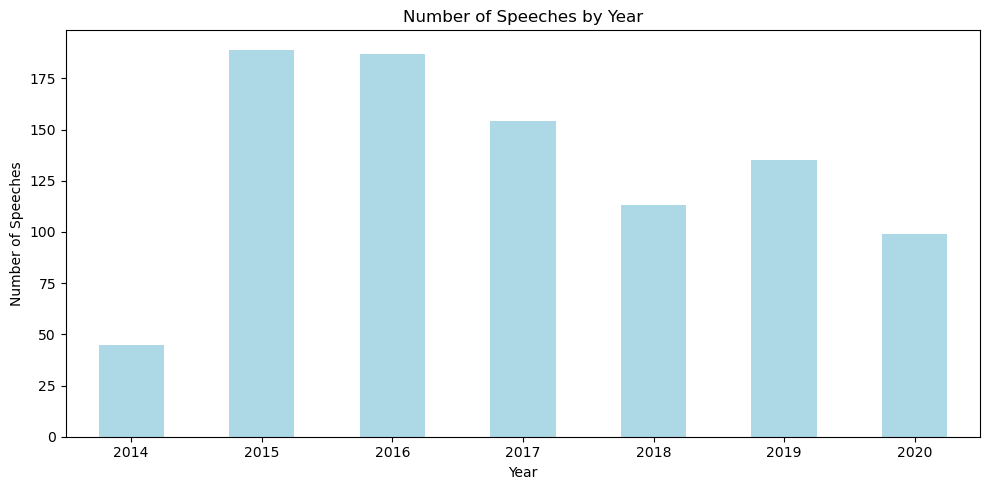

In [12]:
speeches_by_year = speeches_df['date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,5))
speeches_by_year.plot(kind='bar', color='lightblue')
plt.title('Number of Speeches by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The dataset contains text for 922 speeches. The number of speeches by year is as follows. Years 2015 and 2016 had the most number of speeches (approx 180). 

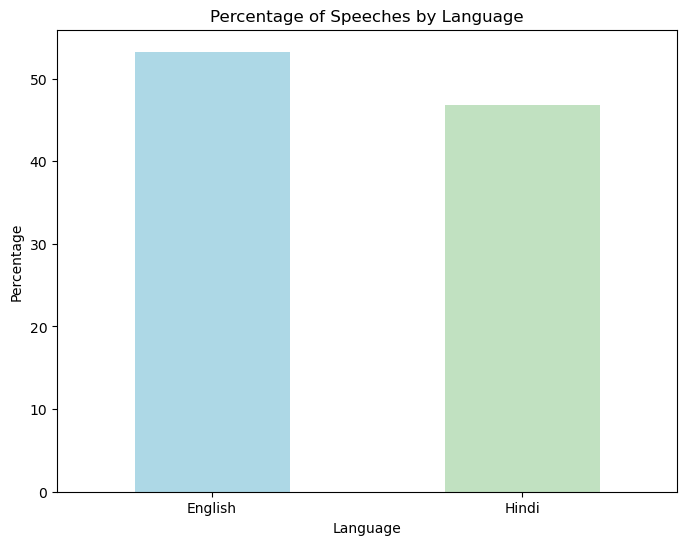

In [13]:
# Total number of english vs Hindi speeches

speeches_by_language_percentage = speeches_df['lang'].value_counts(normalize=True) * 100
speeches_by_language_percentage.index = speeches_by_language_percentage.index.map({'en': 'English', 'hi': 'Hindi'})

plt.figure(figsize=(8, 6))
speeches_by_language_percentage.plot(kind='bar', color=['lightblue', '#C1E1C1'])
plt.title('Percentage of Speeches by Language')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

More than half of the speeches are in english, and we focus on them in our analysis.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u_185569/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


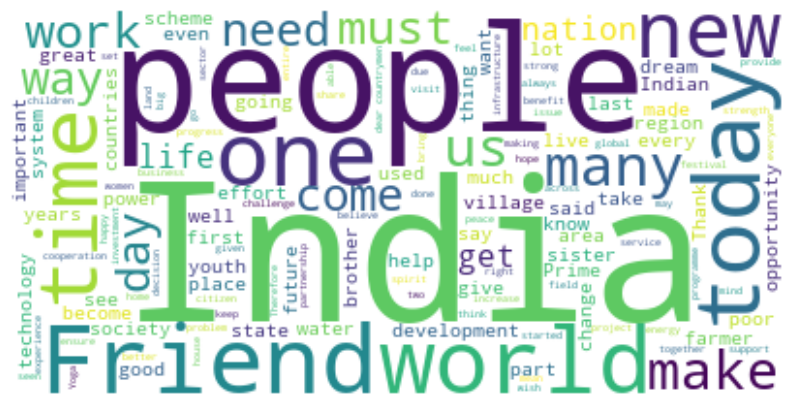

In [14]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
custom_stopwords = {'please', 'question', 'will', 'member', 'country', 'minister', 'thereof', 'country', 'details', 'government', 'whether', 'thereon', 'thereto', 'b', 'c', 'e', 'year', 'three', 'regard', 'therefor', 'taken', 'number', 'reason', 'reasons', 'also', 'would', 'could', 'like', 'u'}
stop_words.update(custom_stopwords)

english_speeches = speeches_df[speeches_df['lang'] == 'en']
all_text_english = ' '.join(english_speeches['text'])

# generate word cloud
wordcloud = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue', stopwords=stop_words)
wordcloud.generate(all_text_english)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Before conducting a deeper analysis on the topics covered, we cleaned the text of the speech to visualize the most common words. Some of the most common words in the text were India, friend, country. “Will” also is a common word that seems to suggest that these speeches detailed the services that the government would deliver on during their term.

### 3. Indian Political Parties Tweets Dataset

We begin by loading and cleaning the dataset for common issues such as duplicates, missing values, and so on. The cleaning is fairly straightforward since the tweets dataset was relatively standardized. The tweets are only for the three major national parties - Indian National Congress, Bhartiya Janta Party, Aam Aadmi Party. 

In [15]:
##Loading and combining the data
df1 = pd.read_csv('3. Political_party_tweets/AamAadmiParty.csv', encoding='utf-8')
df2 = pd.read_csv('3. Political_party_tweets/BJP4India.csv', encoding='utf-8')
df3 = pd.read_csv('3. Political_party_tweets/INCIndia.csv', encoding='utf-8')

In [16]:
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df.columns = combined_df.columns.str.lower().str.replace(' ', '')
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')

In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397531 entries, 0 to 397530
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   datetime   397527 non-null  datetime64[ns, UTC]
 1   tweetid    397530 non-null  object             
 2   text       397530 non-null  object             
 3   username   397524 non-null  object             
 4   likecount  397524 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 15.2+ MB


In [18]:
combined_df = combined_df.dropna()
nan_counts = combined_df.isna().sum()
print(nan_counts)
## Missing Values Done

datetime     0
tweetid      0
text         0
username     0
likecount    0
dtype: int64


In [19]:
combined_df['tweetid'].is_unique
duplicates = combined_df.duplicated('tweetid', keep=False)
non_unique_tweets = combined_df[duplicates]
print(non_unique_tweets)
## Unique ID

Empty DataFrame
Columns: [datetime, tweetid, text, username, likecount]
Index: []


In [20]:
print(combined_df.columns)
sorted_df = combined_df.sort_values(by='datetime', ascending=True)

# Convert 'datetime' column to datetime type if not already
sorted_df['datetime'] = pd.to_datetime(sorted_df['datetime'])

# Set 'datetime' as the index right after sorting
sorted_df.set_index('datetime', inplace=True)

# Define your condition based on the index now
condition = (sorted_df['username'] == 'BJP4India') & (sorted_df.index < '2014-06-01') & (sorted_df.index > '2014-02-01')
subset_df = sorted_df[~condition]

# Ensure subset_df is filtered by a maximum date if needed
subset_df = subset_df[subset_df.index < '2020-12-31']


Index(['datetime', 'tweetid', 'text', 'username', 'likecount'], dtype='object')


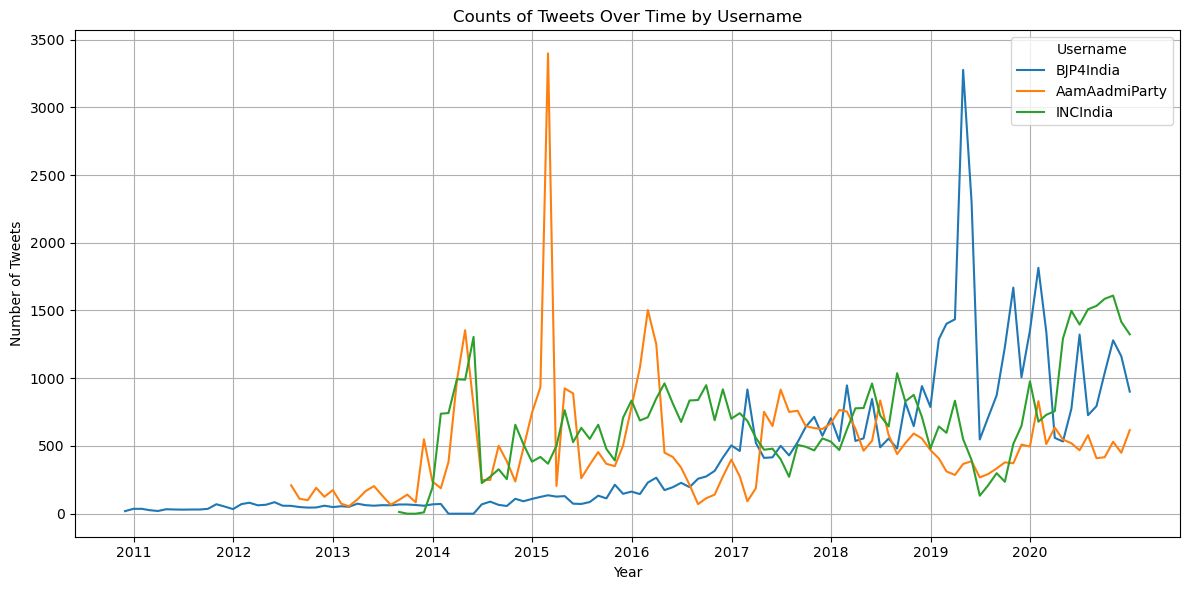

In [21]:
plt.figure(figsize=(12, 6))

# Extract the unique usernames correctly from the DataFrame
unique_usernames = subset_df['username'].unique()

# Plot data for each username
for username in unique_usernames:
    # Filter the data for the current username using the index
    user_df = subset_df[subset_df['username'] == username]

    # Resample at the end of the month and count entries
    user_df = user_df.resample('M').size()  # Using the datetime index for resampling

    plt.plot(user_df.index, user_df, label=username)  # Plot using the index and values

# Set the x-axis major formatter to only show the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Manually set the range of years to be displayed as ticks
if not subset_df.empty:
    min_year = subset_df.index.min().year
    max_year = subset_df.index.max().year
    plt.gca().xaxis.set_major_locator(FixedLocator(
        [mdates.date2num(pd.Timestamp(str(year)+'-01-01')) for year in range(min_year, max_year + 1)]
    ))

plt.title('Counts of Tweets Over Time by Username')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.legend(title='Username')
plt.grid(True)

plt.tight_layout()
plt.show()


After some initial preprocessing of the dataset, we find that the three political parties have roughly similar distributions of tweets over time. Next, we focus only on tweets in english. But first, we would need to detect the language of each tweet to discard the other languages. BJP4India shows a prominent spike around 2014, which coincides with the Indian general elections, where the BJP came into power. There's another spike around 2019, which corresponds with another general election period. AamAadmiParty shows a gradual increase in activity over the years, with notable spikes that could be associated with local elections in Delhi, where the party has a strong presence.Towards the most recent years shown in the graph (2021-2023), there's a decrease in the number of tweets for BJP, while AAP shows a more consistent level of activity. There are fluctuations in tweet volumes for all parties, which could be related to the changing dynamics of political campaigns and the influence of social media strategies.

In [22]:
#subset_df.reset_index()
#def detect_language_with_progress(text, index, total):
#    try:
#        # Print progress every 5000 rows
#        if index % 10000 == 0:
#            print(f"Processing row {index+1}/{total}")
#        return detect(text)
#    except LangDetectException:
#        return "unknown"

#total_rows = len(subset_df)
#subset_df['script'] = [detect_language_with_progress(row, idx, total_rows) for idx, row in enumerate(subset_df['text'])]

# Now you can get the value counts
#script_value_counts = subset_df['script'].value_counts()
#print(script_value_counts)
## Commenting this out because it takes FOREVER TO RUN

In [23]:
#subset_df.to_csv('IntermediateOutput.csv',encoding='utf-8', index=True)

In [24]:
# Load the data
subset_df = pd.read_csv('3. Political_party_tweets/IntermediateOutput.csv', encoding='utf-8')
subset_df['datetime'] = pd.to_datetime(subset_df['datetime'], errors='coerce').dt.tz_localize(None)

max_date = pd.Timestamp('2020-12-31')
min_exclude_date = pd.Timestamp('2014-02-01')
max_exclude_date = pd.Timestamp('2014-06-01')
subset_df = subset_df[subset_df['datetime'] <= max_date]

subset_df = subset_df[~((subset_df['username'] == 'BJP4India') & (subset_df['datetime'] >= min_exclude_date) & (subset_df['datetime'] <= max_exclude_date))]


In [25]:
subset_df['datetime'] = pd.to_datetime(subset_df['datetime'], errors='coerce')
subset_df = subset_df.dropna(subset=['datetime'])
subset_df['year'] = subset_df['datetime'].dt.year
yearly_tweet_counts = subset_df.groupby('year').size()
print(yearly_tweet_counts)

filtered_df = subset_df[(subset_df['datetime'] >= '2014-01-01') & (subset_df['script'] == 'en')]


year
2010       55
2011      431
2012     1640
2013     2888
2014    14624
2015    17794
2016    19089
2017    19947
2018    24211
2019    27545
2020    34101
dtype: int64


Finally, we clean the content of the tweets to remove any URLs, punctuations and special characters.

In [26]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

# Apply the clean_text function to the 'cleaned_text' column of your DataFrame
filtered_df['text'] = filtered_df['text'].apply(clean_text)

# Output the DataFrame to verify
print(filtered_df.head())

      Unnamed: 0            datetime   index             tweetid  \
5015        5015 2014-01-01 09:24:05   63834  418311657329131520   
5016        5016 2014-01-01 09:41:35  397316  418316058924052481   
5017        5017 2014-01-01 10:14:56   63833  418324454020640769   
5018        5018 2014-01-01 10:26:08   63832  418327273842806784   
5019        5019 2014-01-01 10:47:47  291264  418332720599539712   

                                                   text       username  \
5015  live webcast of proceedings of first session o...  AamAadmiParty   
5016  watch  rewind  2013 congress vice president ra...       INCIndia   
5017  lets kick off year 2014 by getting 2014 suppor...  AamAadmiParty   
5018  donate amount 2014 for better india on new yea...  AamAadmiParty   
5019  volunteer for mission 272\n\ngive missed call ...      BJP4India   

      likecount script  year  
5015       23.0     en  2014  
5016       16.0     en  2014  
5017       23.0     en  2014  
5018       42.0     en

In [27]:
filtered_df.to_csv('final_clean_tweets.csv', index=False)

In [28]:
data = pd.read_csv('final_clean_tweets.csv')

# Convert the 'date' column to datetime format assuming 'date' is the column name
data['date'] = pd.to_datetime(data['datetime'], errors='coerce')

# Filter out rows where the date conversion resulted in NaT
data = data.dropna(subset=['date'])

# Group data by year and username to count tweets
annual_tweet_counts = data.groupby([data['date'].dt.year, 'username']).size().unstack(fill_value=0)

# Print the annual tweet counts by username
annual_tweet_counts

username  AamAadmiParty  BJP4India  INCIndia
date                                        
2014               5216        471      6298
2015               6711        882      5865
2016               4718       1786      7320
2017               3645       3754      4910
2018               2954       3758      6394
2019               2215       5081      3699
2020               2743       4261      7350

Once we have the final clean tweets, we look at weather there is a strong relationship between the themes across parties, and over time. To do this, we create a map of thematic keywords to create an approximate mapping of some major buckets. 

In [29]:
from collections import Counter
# Load the dataset
file_path = 'final_clean_tweets.csv'
data = pd.read_csv(file_path, low_memory=False)

# Convert the 'date' column to datetime format assuming 'date' is the column name
data['date'] = pd.to_datetime(data['datetime'],errors='coerce')

# Group data by year and username to count tweets
annual_tweet_counts = data.groupby([data['date'].dt.year, 'username']).size().unstack(fill_value=0)

# Print the annual tweet counts by username
print(annual_tweet_counts)

# Function to extract keywords for thematic analysis
def extract_keywords(text):
    keywords = re.findall(r'\b[\w]+\b', text.lower())  # Split into words and convert to lowercase
    return keywords

# List of potential thematic categories and keywords associated with them
thematic_keywords = {
    'Health': ['health', 'hospital', 'medicine', 'doctor', 'healthcare', 'treatment', 'nurse', 'medical'],
    'Education': ['education', 'school', 'university', 'college', 'student', 'teacher', 'learning', 'scholarship'],
    'Infrastructure': ['road', 'infrastructure', 'construction', 'bridge', 'highway', 'transport', 'railway'],
    'Economy': ['economy', 'inflation', 'tax', 'budget', 'financial', 'money', 'investment', 'trade'],
    'Agriculture': ['agriculture', 'farmer', 'crop', 'farming', 'rural', 'land', 'agricultural'],
    'Governance': ['policy', 'government', 'law', 'reform', 'regulation', 'legislation', 'civic', 'order'],
    'Technology': ['technology', 'digital', 'internet', 'software', 'data', 'cyber', 'tech'],
    'Environment': ['environment', 'climate', 'pollution', 'sustainability', 'green', 'conservation', 'eco'],
    'Employment': ['employment', 'job', 'work', 'unemployment', 'labor', 'hire', 'worker'],
    'Social Issues': ['rights', 'equality', 'justice', 'welfare', 'community', 'social', 'issue'],
    'Energy': ['energy', 'power', 'solar', 'oil', 'gas', 'renewable', 'electricity']
}

# Function to categorize tweets based on thematic keywords
def categorize_by_theme(text, themes):
    categories = []
    text = text.lower()  # Convert to lowercase for matching
    for theme, keywords in themes.items():
        if any(keyword in text for keyword in keywords):
            categories.append(theme)
    return categories

# Clean the text column to ensure all entries are strings
data['text'] = data['text'].astype(str)

# Apply categorization to each tweet
data['themes'] = data['text'].apply(lambda x: categorize_by_theme(x, thematic_keywords))

# Display the distribution of themes
theme_counts = Counter([theme for sublist in data['themes'] for theme in sublist])
print(theme_counts.most_common())


username  AamAadmiParty  BJP4India  INCIndia
date                                        
2014.0             5216        471      6298
2015.0             6711        882      5865
2016.0             4718       1786      7320
2017.0             3645       3754      4910
2018.0             2954       3758      6394
2019.0             2215       5081      3699
2020.0             2743       4261      7350
[('Governance', 7286), ('Environment', 6331), ('Economy', 6220), ('Employment', 5995), ('Social Issues', 4825), ('Agriculture', 4742), ('Education', 4491), ('Energy', 3679), ('Health', 2760), ('Infrastructure', 2720), ('Technology', 1332)]


In [30]:
# Create a DataFrame to hold username and themes
user_theme_data = data[['username', 'themes']]

# Create a dictionary to count themes per username
theme_counts_by_user = {}

for index, row in user_theme_data.iterrows():
    if row['username'] not in theme_counts_by_user:
        theme_counts_by_user[row['username']] = Counter()
    theme_counts_by_user[row['username']].update(row['themes'])

# Convert the dictionary to a DataFrame for better display and analysis
user_theme_df = pd.DataFrame.from_dict(theme_counts_by_user, orient='index').fillna(0)

# Rename columns to reflect the theme for clarity
user_theme_df.columns = [f'Theme: {col}' for col in user_theme_df.columns]

# Optionally, sort the DataFrame by username
user_theme_df.sort_index(inplace=True)

# Display the resulting DataFrame
print(user_theme_df.head())


               Theme: Governance  Theme: Energy  Theme: Environment  \
AamAadmiParty               2166           1210                1505   
BJP4India                   2231           1041                1580   
INCIndia                    2889           1428                3246   

               Theme: Education  Theme: Employment  Theme: Social Issues  \
AamAadmiParty              2737               1594                  1200   
BJP4India                   509               1539                  1036   
INCIndia                   1245               2862                  2589   

               Theme: Health  Theme: Technology  Theme: Economy  \
AamAadmiParty           1276                239            1461   
BJP4India                615                577            1837   
INCIndia                 869                516            2922   

               Theme: Infrastructure  Theme: Agriculture  
AamAadmiParty                    949                 824  
BJP4India              

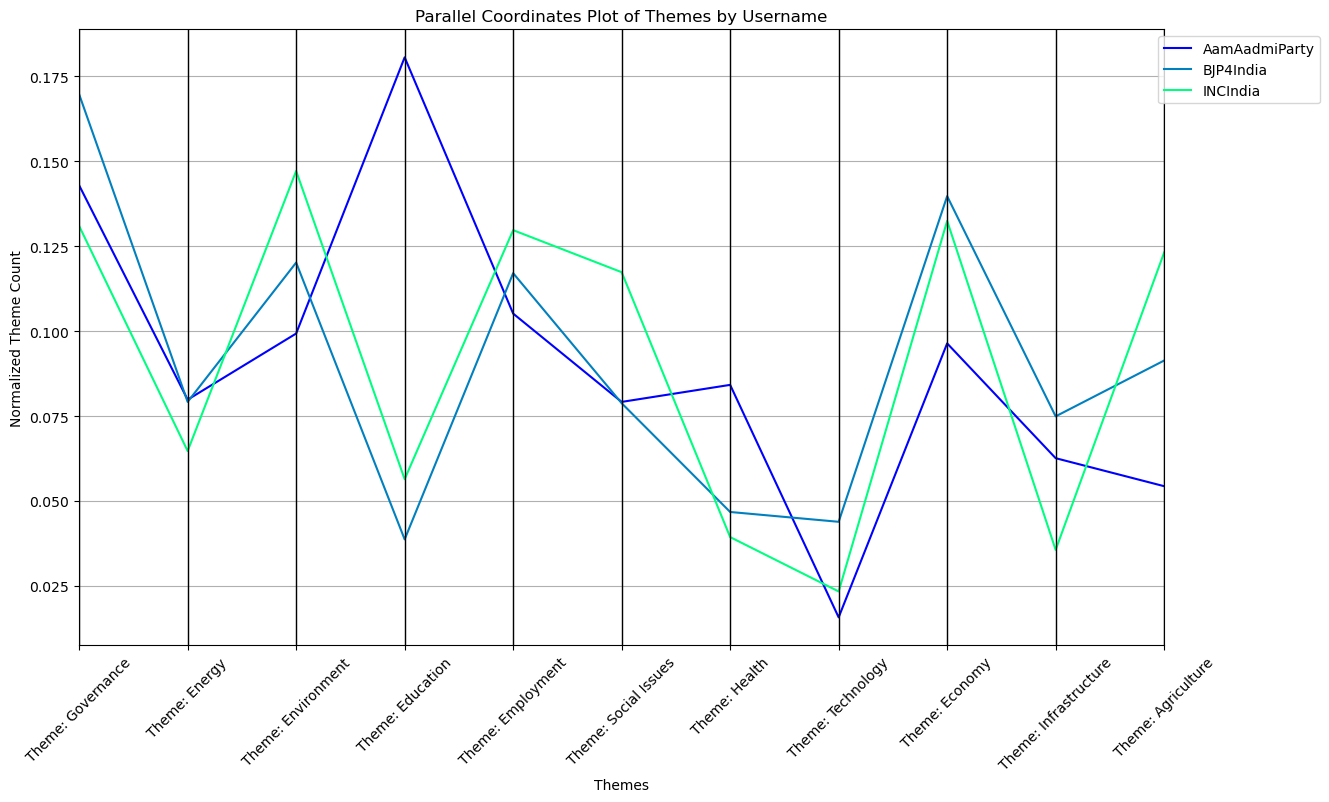

In [31]:
# Normalize data for better visualization
from pandas.plotting import parallel_coordinates
normalized_df = user_theme_df.div(user_theme_df.sum(axis=1), axis=0)
normalized_df.reset_index(inplace=True)
normalized_df.rename(columns={'index': 'Username'}, inplace=True)

plt.figure(figsize=(14, 8))
parallel_coordinates(normalized_df, 'Username', colormap='winter')
plt.title('Parallel Coordinates Plot of Themes by Username')
plt.ylabel('Normalized Theme Count')
plt.xlabel('Themes')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

This chart shows how the tweets vary across themes for all three parties. This analysis is done by creating a word map of the major themes and the main keywords associated with them, and finally matching each tweet to one or more of the themes.

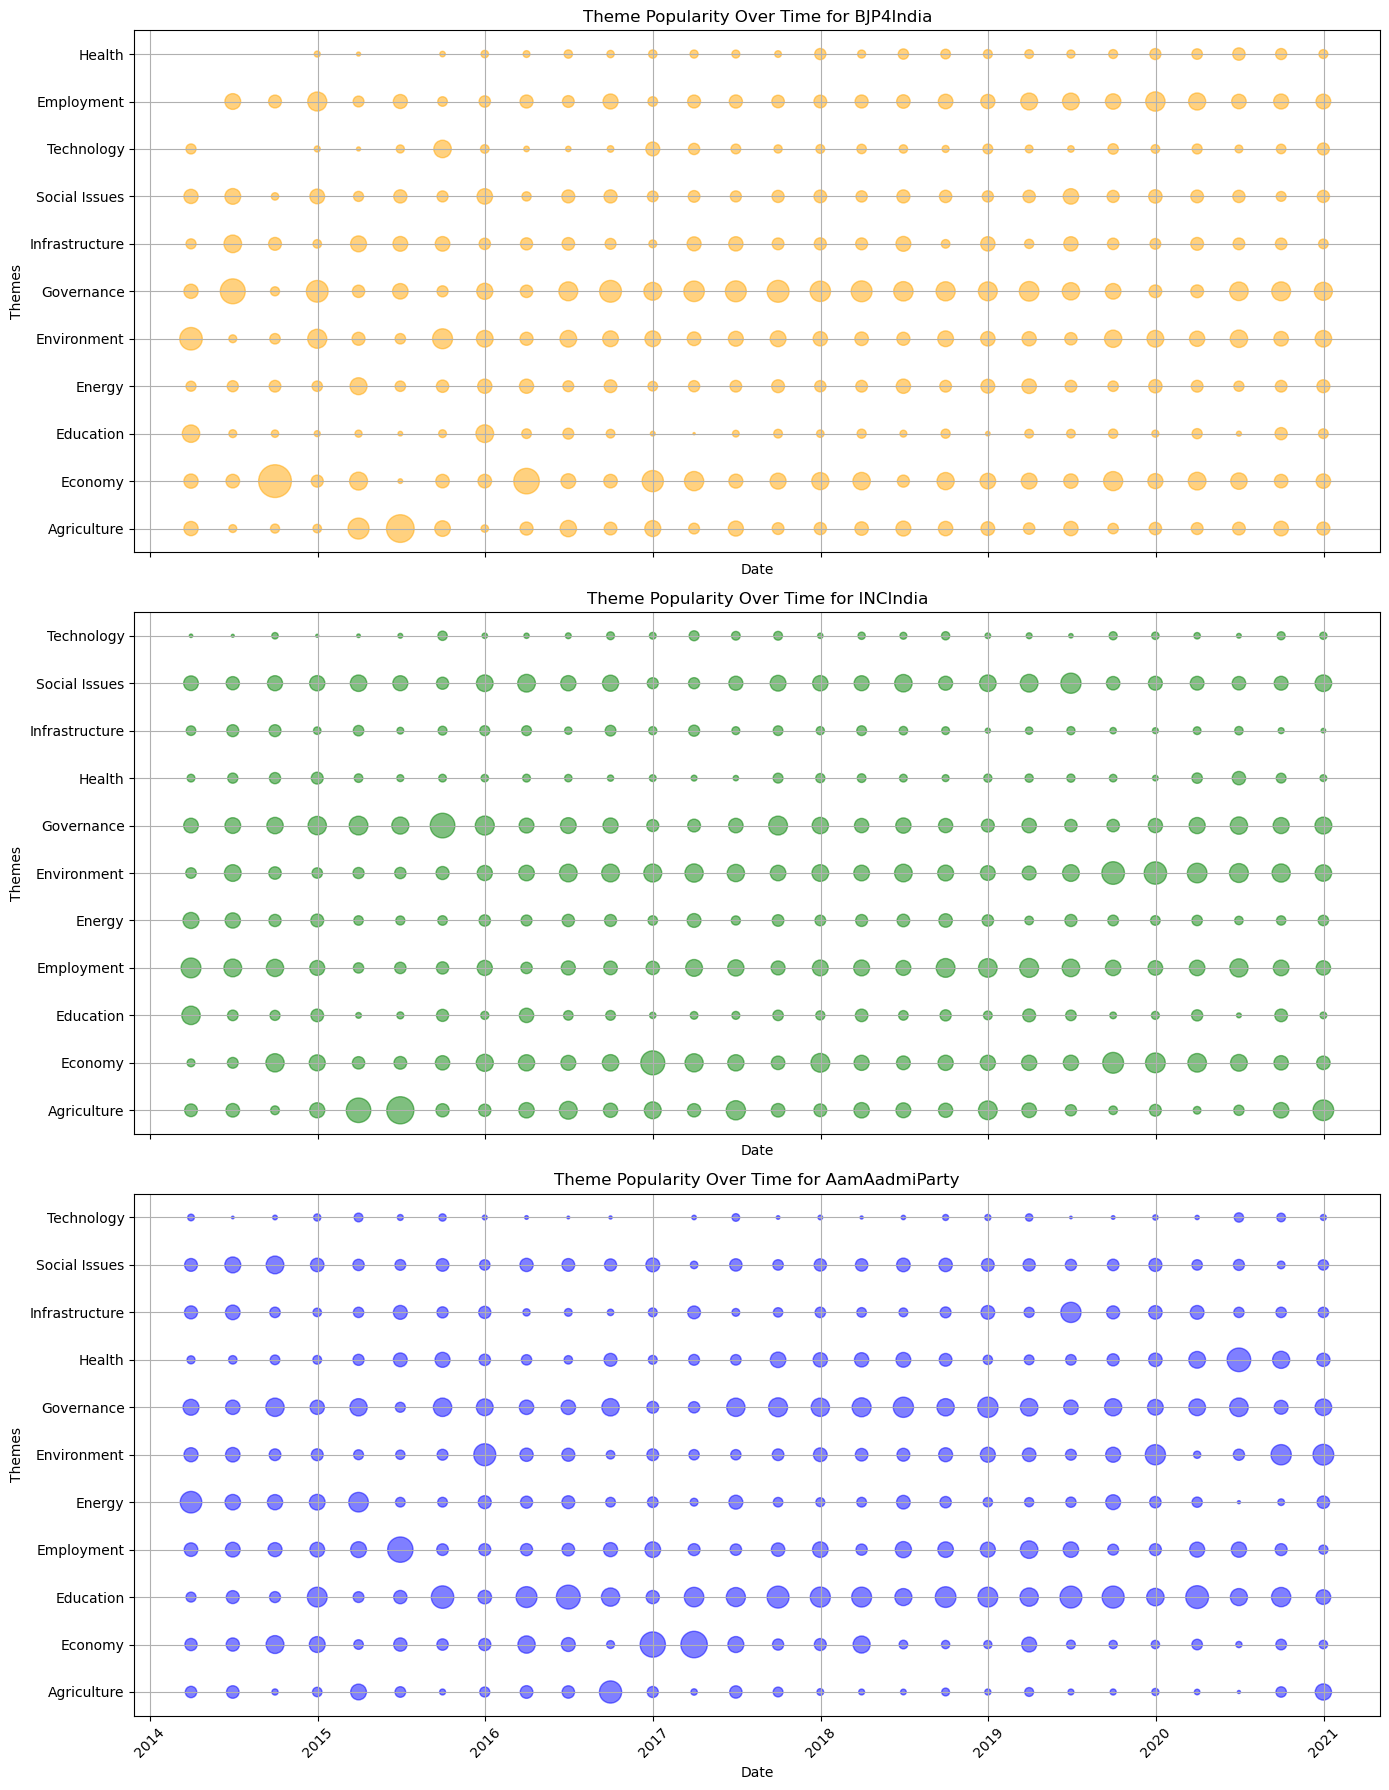

In [32]:
data['date'] = pd.to_datetime(data['datetime'],errors='coerce')

# Exploding the list of themes into separate rows for each theme
data_exploded = data.explode('themes')

# Grouping by quarter, username, and themes to count occurrences
theme_counts = data_exploded.groupby([pd.Grouper(key='date', freq='Q'), 'username', 'themes']).size().reset_index(name='counts')

# Normalize bubble sizes within each quarter and username
theme_counts['size'] = theme_counts.groupby(['date', 'username'])['counts'].transform(lambda x: x / x.sum())
fig, axes = plt.subplots(nrows=3, figsize=(14, 18), sharex=True)

# Color mapping for users
colors = ['orange', 'green', 'blue']
usernames = ['BJP4India', 'INCIndia', 'AamAadmiParty']

for ax, username, color in zip(axes, usernames, colors):
    user_data = theme_counts[theme_counts['username'] == username]
    ax.scatter(user_data['date'], user_data['themes'], s=user_data['size']*1000, alpha=0.5, color=color)
    ax.set_title(f'Theme Popularity Over Time for {username}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Themes')
    ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


These charts show how the tweets vary across themes within parties and over time. For instance, AAP has more education focused tweets relative to the other parties. However, these is no clear pattern when we observe tweets over time for any particular party.

## PART C: Modeling and Training Details

**Our approach answers three questions:**

1. Can we classify the questions asked by the political party or tweets posted by the party as BJP (the national party) or non-BJP?
2. What are the main themes being discussed across our different datasets? Does it vary by medium of communication by party?
3. What are the sentiments expressed in the various types of text data across different mediums?

### 1. BERT model for the Parliamentary questions data

Unlike TF-IDF which just converts text to a numeric form, BERT understands the context of each word in relation to the words around it. This leads to a more nuanced understanding and processing of text. It is also effective in handling words with multiple meanings, based on the context.

In [33]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenization function
def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
        return_tensors='tf'
    )

# Example data preparation
train_x, validate_x, train_y, validate_y = train_test_split(
    df['question_text'],
    df['BJP'],
    test_size=0.10,
    random_state=109,
    stratify=df['BJP']
)

# Tokenize data
train_tokenized = tokenize_texts(train_x, max_length=128)
validate_tokenized = tokenize_texts(validate_x, max_length=128)

# Save the processed input data as train_x_processed and validate_x_processed
train_x_processed = {'input_ids': train_tokenized['input_ids'], 'attention_mask': train_tokenized['attention_mask']}
validate_x_processed = {'input_ids': validate_tokenized['input_ids'], 'attention_mask': validate_tokenized['attention_mask']}


# Create TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_tokenized['input_ids'], 'attention_mask': train_tokenized['attention_mask']}, train_y))
validation_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': validate_tokenized['input_ids'], 'attention_mask': validate_tokenized['attention_mask']}, validate_y))

batch_size=32
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


2024-05-08 19:05:17.140911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:05:17.145858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:05:17.148866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [34]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
##CALLBACKS
checkpoint_filepath = 'bert_checkpoint/bert_checkpoint.tf'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

def scheduler(epoch, lr):
    return lr * 0.9 if epoch > 3 else lr

lr_scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [36]:
# model training

#history = model.fit(
 #   train_dataset,
 #   validation_data=validation_dataset,
 #   epochs=3,
 #   callbacks=[lr_scheduler_callback, early_stopping_callback, model_checkpoint_callback]
 #)

#history_dict = {key: np.array(value).tolist() for key, value in history.history.items()}

#with open('training_history.json', 'w') as f:
#    json.dump(history_dict, f)


In [37]:
model.load_weights('bert_checkpoint/bert_checkpoint.tf')

In [38]:
model.save_weights('new_checkpoint_format/')
model.load_weights('new_checkpoint_format/')

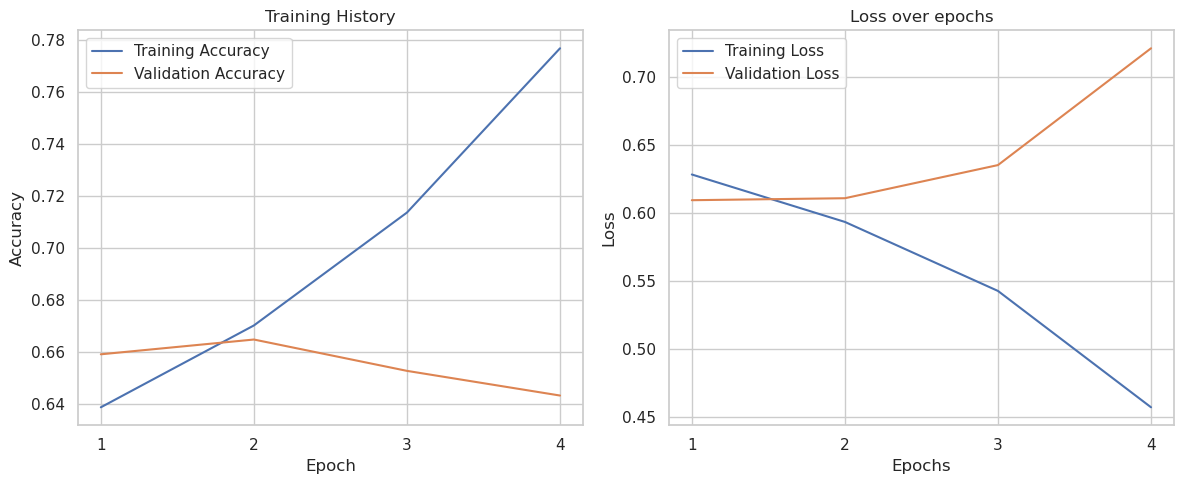

In [39]:
#Model performance over epochs
sns.set(style="whitegrid")

with open('bert_checkpoint/training_history.json', 'r') as file:
    data = json.load(file)

accuracy = data['accuracy']
val_accuracy = data['val_accuracy']
loss = data['loss']
val_loss = data['val_loss']

epochs = len(accuracy)

plt.figure(figsize=(12, 5))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), data['accuracy'], label='Training Accuracy')
plt.plot(range(1, epochs + 1), data['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(1, epochs + 1))

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), data['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), data['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, epochs + 1))

plt.tight_layout()
plt.show()


We train our model for 5 epochs also using a learning rate scheduler and callbacks. Plotting the training history and loss over epochs, we find that while the training accuracy follows an expected increasing trend over epochs, validation accuracy has peaks around epoch 2 and then drops slightly. Similarly for the loss, we find that the loss does not improve significantly with more epochs. This indicates that there might be possible overfitting as we increase epochs.

In [40]:
bert_output = model.predict(validation_dataset)
bert_logits = bert_output['logits']
bert_predictions = tf.nn.softmax(bert_logits)
bert_predictions = bert_predictions.numpy()
bert_pred_classes = np.argmax(bert_predictions, axis=1)

2024-05-08 19:05:33.690526: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


452/452 [==============================] - 117s 243ms/step


In [41]:
print("Sample BERT predictions:", bert_pred_classes[:100])

Sample BERT predictions: [0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]


_Accuracy of the model by Ministry or Theme_

In [42]:
validate_df = pd.DataFrame({
    'question_text': validate_x,
})
validate_df['ministry'] = df.loc[validate_x.index, 'ministry']

In [43]:
validate_df['predicted'] = bert_pred_classes

In [44]:
def calculate_accuracy(group):
    correct_predictions = (group['predicted'] == group['BJP']).sum()
    total_predictions = len(group)
    return correct_predictions / total_predictions

validate_df['BJP'] = validate_y.values


accuracy_by_ministry = validate_df.groupby('ministry').apply(calculate_accuracy)


For model training, we implemented several callbacks:​

- Model checkpointing to save the best-performing model based on validation accuracy​

- Early stopping to prevent overfitting by halting training if validation loss didn't improve for three epochs​

- Learning rate scheduler that reduced the rate by 10% after the third epoch to aid in model fine-tuning​
​

### 2. Prime Minister Narendra Modi's Speeches

In [47]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import string

In [48]:
# stopwords are the most common words in a language (such as "the", "is", "in", and "and") and do not add much meaning to the text.
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

custom_stopwords = {'please', 'thank', 'regard', 'also', 'may', 'must', 'might', 'etc', 'india', 'country', 'make', 'one', 'today', 'get',
                    'come', 'we', 'day', 'I', 'i', 'friend', 'people', 'say', 'see'}
stop_words.update(custom_stopwords)

# process text
def preprocess_text(text):
    doc = nlp(text.lower().strip())
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
    return tokens

# preprocess text of each speech
english_speeches['processed_text'] = english_speeches['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u_185569/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# create dictionary and corpus
speeches_texts = english_speeches['processed_text'].tolist()
dictionary = Dictionary(speeches_texts)
corpus = [dictionary.doc2bow(text) for text in speeches_texts]

In [51]:
num_topics = 7

# train model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

In [52]:
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.007*"time" + 0.007*"government" + 0.006*"year" + 0.006*"new" + 0.006*"take" + 0.006*"many" + 0.005*"work" + 0.005*"every" + 0.005*"go" + 0.005*"life"
Topic: 1 
Words: 0.008*"world" + 0.007*"technology" + 0.007*"partnership" + 0.007*"development" + 0.006*"indian" + 0.006*"nation" + 0.005*"science" + 0.005*"new" + 0.005*"minister" + 0.004*"president"
Topic: 2 
Words: 0.007*"lord" + 0.006*"rama" + 0.005*"ram" + 0.005*"world" + 0.005*"great" + 0.004*"year" + 0.004*"shri" + 0.004*"new" + 0.004*"every" + 0.004*"many"
Topic: 3 
Words: 0.010*"cooperation" + 0.008*"partnership" + 0.008*"president" + 0.008*"region" + 0.007*"economic" + 0.007*"excellency" + 0.006*"world" + 0.006*"minister" + 0.006*"visit" + 0.005*"new"
Topic: 4 
Words: 0.009*"world" + 0.009*"year" + 0.007*"new" + 0.007*"sector" + 0.007*"government" + 0.006*"global" + 0.005*"economy" + 0.005*"take" + 0.005*"business" + 0.005*"investment"
Topic: 5 
Words: 0.012*"world" + 0.008*"yoga" + 0.005*"time" + 0.005*"take"

LDA: The unsupervised model identifies topics as characterized by certain words that appear more frequently in that topic. Latent Dirichlet Allocation (LDA) is a type of probabilistic model specifically designed for uncovering the underlying topics present in a collection of documents. Here's a more detailed breakdown of what LDA does:
Topic Representation: LDA assumes that each topic is a distribution over words. This means that each topic is characterized by certain words that appear more frequently in that topic. For instance, a "sports" topic might frequently include words like "football," "game," and "team."

We used LDA for thematic analysis of speech data. This is a unsupervised learning model which looks at each topic as a distribution of words that tend to appear together. 
t is an unsupervised learning model meaning LDA tries to learn these topics and their distributions within documents without any pre-labeled data.
The number of topics is a parameter that needs to be specified beforehand. After several iterations we chose 7 so that it is not too broad, nor too disaggregated.
The choice of Hyper -parameters here was the number of topics < 5 were very broad and more than 7/8 were too disaggregated. (5-7)
For each of these 7 topics, we get a list of words that are most representative of that topic, such as governmental and so on. 



### 3. Political party tweets dataset

Finally, we look at the BERT model trained on the questions database and see if the same model can predimt the party of the tweet (BJP affiliation or not) with reasonable accuracy. 

In [53]:
df_tweets = pd.read_csv('final_clean_tweets.csv', encoding='utf-8')

df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'],errors='coerce')
df_tweets['year'] = df_tweets['datetime'].dt.year

df_tweets.groupby('year').size()

year
2014.0    11986
2015.0    13458
2016.0    13824
2017.0    12309
2018.0    13106
2019.0    10995
2020.0    14354
dtype: int64

In [54]:
df_tweets['BJP'] = np.where(df_tweets['username'] == 'BJP4India', 1, 0)

In [55]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenization function
def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
        return_tensors='tf'
    )

# Assuming df_tweets is already defined and processed as per previous steps
train_x_t, validate_x_t, train_y_t, validate_y_t = train_test_split(
    df_tweets['text'],
    df_tweets['BJP'],
    test_size=0.10,
    random_state=109,
    stratify=df_tweets['BJP']
)


In [56]:
# Tokenization of text
train_tokenized = tokenize_texts(train_x_t.tolist(), max_length=128)
validate_tokenized = tokenize_texts(validate_x_t.tolist(), max_length=128)

# Creating TensorFlow datasets
train_dataset_t = tf.data.Dataset.from_tensor_slices(({'input_ids': train_tokenized['input_ids'], 'attention_mask': train_tokenized['attention_mask']}, train_y_t))
validation_dataset_t = tf.data.Dataset.from_tensor_slices(({'input_ids': validate_tokenized['input_ids'], 'attention_mask': validate_tokenized['attention_mask']}, validate_y_t))



In [57]:
# Setting up batching and prefetching
batch_size = 32
train_dataset_t = train_dataset_t.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset_t = validation_dataset_t.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model preparation
model_tweet = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
model_tweet.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# Loading weights (Ensure the file path is correct)
model_tweet.load_weights('new_checkpoint_format/')

In [59]:
# Model prediction
bert_output_t = model_tweet.predict(validation_dataset_t)
bert_predictions_t = tf.nn.softmax(bert_output_t.logits)
bert_pred_classes_t = np.argmax(bert_predictions_t.numpy(), axis=1)
true_classes_t = validate_y_t.values


282/282 [==============================] - 72s 242ms/step


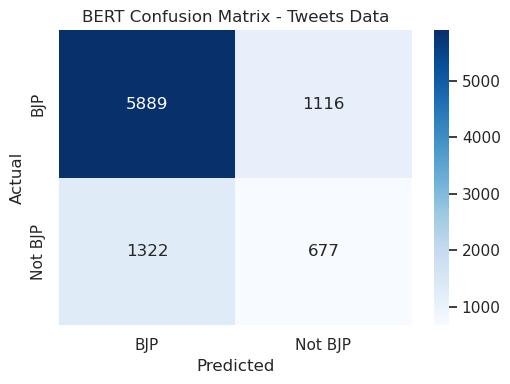

In [60]:
# Confusion Matrix visualization
bert_cm_t = confusion_matrix(true_classes_t, bert_pred_classes_t)
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.heatmap(bert_cm_t, annot=True, fmt='d', cmap='Blues', xticklabels=['BJP', 'Not BJP'], yticklabels=['BJP', 'Not BJP'])
plt.title('BERT Confusion Matrix - Tweets Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


The BERT model trained on questions data has about 73% accuracy on the tweets data, highlighting possibly similar use of texts by the ruling party BJP across mediums of communication. The model’s precision is 81.68% and the recall is 76.34%, showing better performance on the tweets in terms of both precision and recall compared to the parliamentary questions dataset.​ 

## PART D: Results from Theme Extraction

### 1. Resuts from the BERT model for the Parliamentary questions data

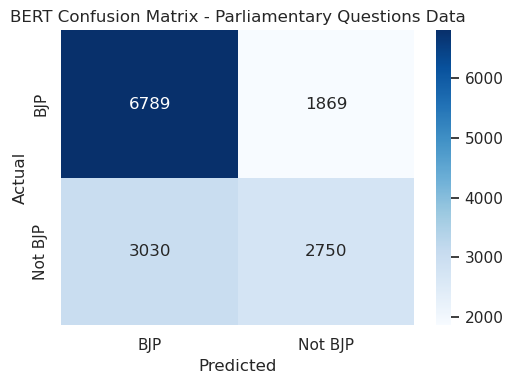

In [61]:
true_classes = validate_y.values

# bert
bert_cm = confusion_matrix(true_classes, bert_pred_classes)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BJP', 'Not BJP'], yticklabels=['BJP', 'Not BJP'])
plt.title('BERT Confusion Matrix - Parliamentary Questions Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

In [62]:
validate_texts = validate_x.tolist()
# Extracting indices where predictions are 1 (not irrelevant) for both models
bert_BJP_indices = [i for i, pred in enumerate(bert_pred_classes) if pred == 1]
bert_not_BJP_indices = [i for i, pred in enumerate(bert_pred_classes) if pred == 0]

# Fetching the first 2 "not irrelevant" abstracts according to each model
bert_BJP = [validate_texts[i] for i in bert_BJP_indices[:2]]
bert_other_party = [validate_texts[i] for i in bert_not_BJP_indices[:2]]

In [63]:
print("BERT Model - 2 Questions from BJP Minister:")
for idx, question_text in enumerate(bert_BJP, 1):
    print(f"{idx}. {question_text}")

print("BERT Model - 2 Questions from non-BJP Minister:")
for idx, question_text in enumerate(bert_other_party, 1):
    print(f"{idx}. {question_text}")

BERT Model - 2 Questions from BJP Minister:
1. Will the Minister of HEALTH AND FAMILY WELFARE be pleased to state:  (a) whether the Government has eradicated several diseases in the country, if so, the details thereof during the last three years, State/UT-wise;  (b) whether the Government has noted recurrence of several diseases on a large scale in the country, if so, the details thereof and the list of such diseases, State/UT-wise;  (c) whether the Government has conducted any study in this regard, if so, the details thereof and the outcome thereon; and  (d) the steps taken by the Government to curb recurrence of eradicated diseases?
2. (a) whether the American companies such as Pepsi, Coca Cola, Nestle have submitted any application to do business in the food processing sector in the country;  (b) if so, the details thereof; and  (c) the action taken by the Government in this regard?
BERT Model - 2 Questions from non-BJP Minister:
1. (a) the funds earmarked/allocated under Swachh Bha

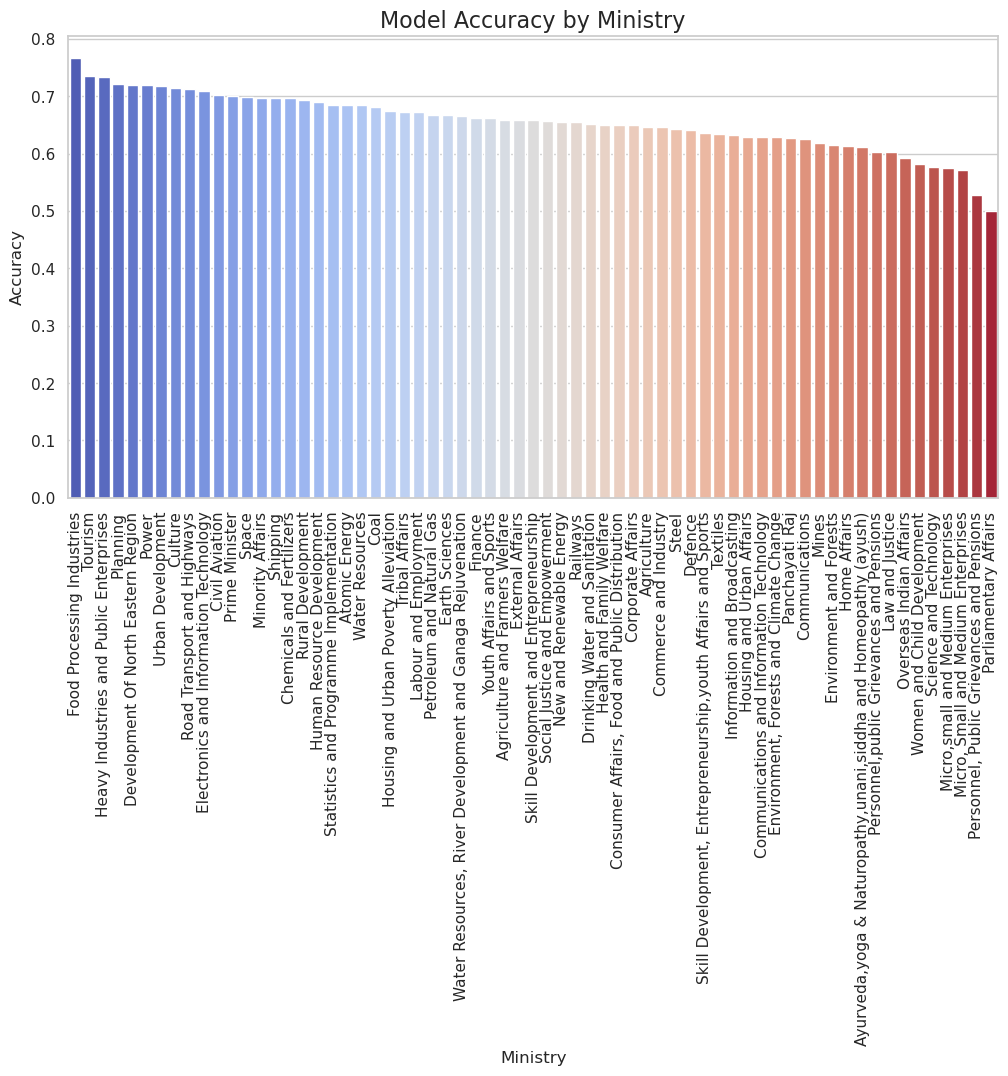

In [65]:
accuracy_df = accuracy_by_ministry.reset_index()
accuracy_df.columns = ['Ministry', 'Accuracy']
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Ministry', y='Accuracy', data=accuracy_df, palette='coolwarm')
plt.title('Model Accuracy by Ministry', fontsize=16)
plt.xlabel('Ministry', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=90)
plt.show()

The training history shows that while training accuracy consistently increased, reaching 78% by the fourth epoch, validation accuracy peaked at 66% in the second epoch. So we can see overfitting past the second epoch, which triggered the early stopping.​
​The model achieves a precision of 72.46% and a recall of 67.89%​

​True Positives (Correctly identified as BJP): The model correctly identified 67.89% of the BJP questions (6789 out of 10019 actual BJP questions).​

False Negatives (BJP questions incorrectly labeled as Not BJP): 30.30% of BJP questions were misclassified as not being from the BJP (3030 out of 10019 actual BJP questions).​

False Positives (Not BJP questions incorrectly labeled as BJP): 40.44% of non-BJP questions were incorrectly classified as BJP (1869 out of 4620 actual not BJP questions).​

True Negatives (Correctly identified as not BJP): 59.56% of non-BJP questions were correctly identified as not BJP (2750 out of 4620 actual not BJP questions).​


### 2. Results from the Speeches Data

In [66]:
def extract_top_words(lda_model, num_topics, num_words):
    top_words_per_topic = []
    for t in range(num_topics):
        top_words = [lda_model.id2word[i] for i, _ in lda_model.get_topic_terms(t, topn=num_words)]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

num_topics = 7
num_words = 10
top_words_per_topic = extract_top_words(lda_model, num_topics, num_words)

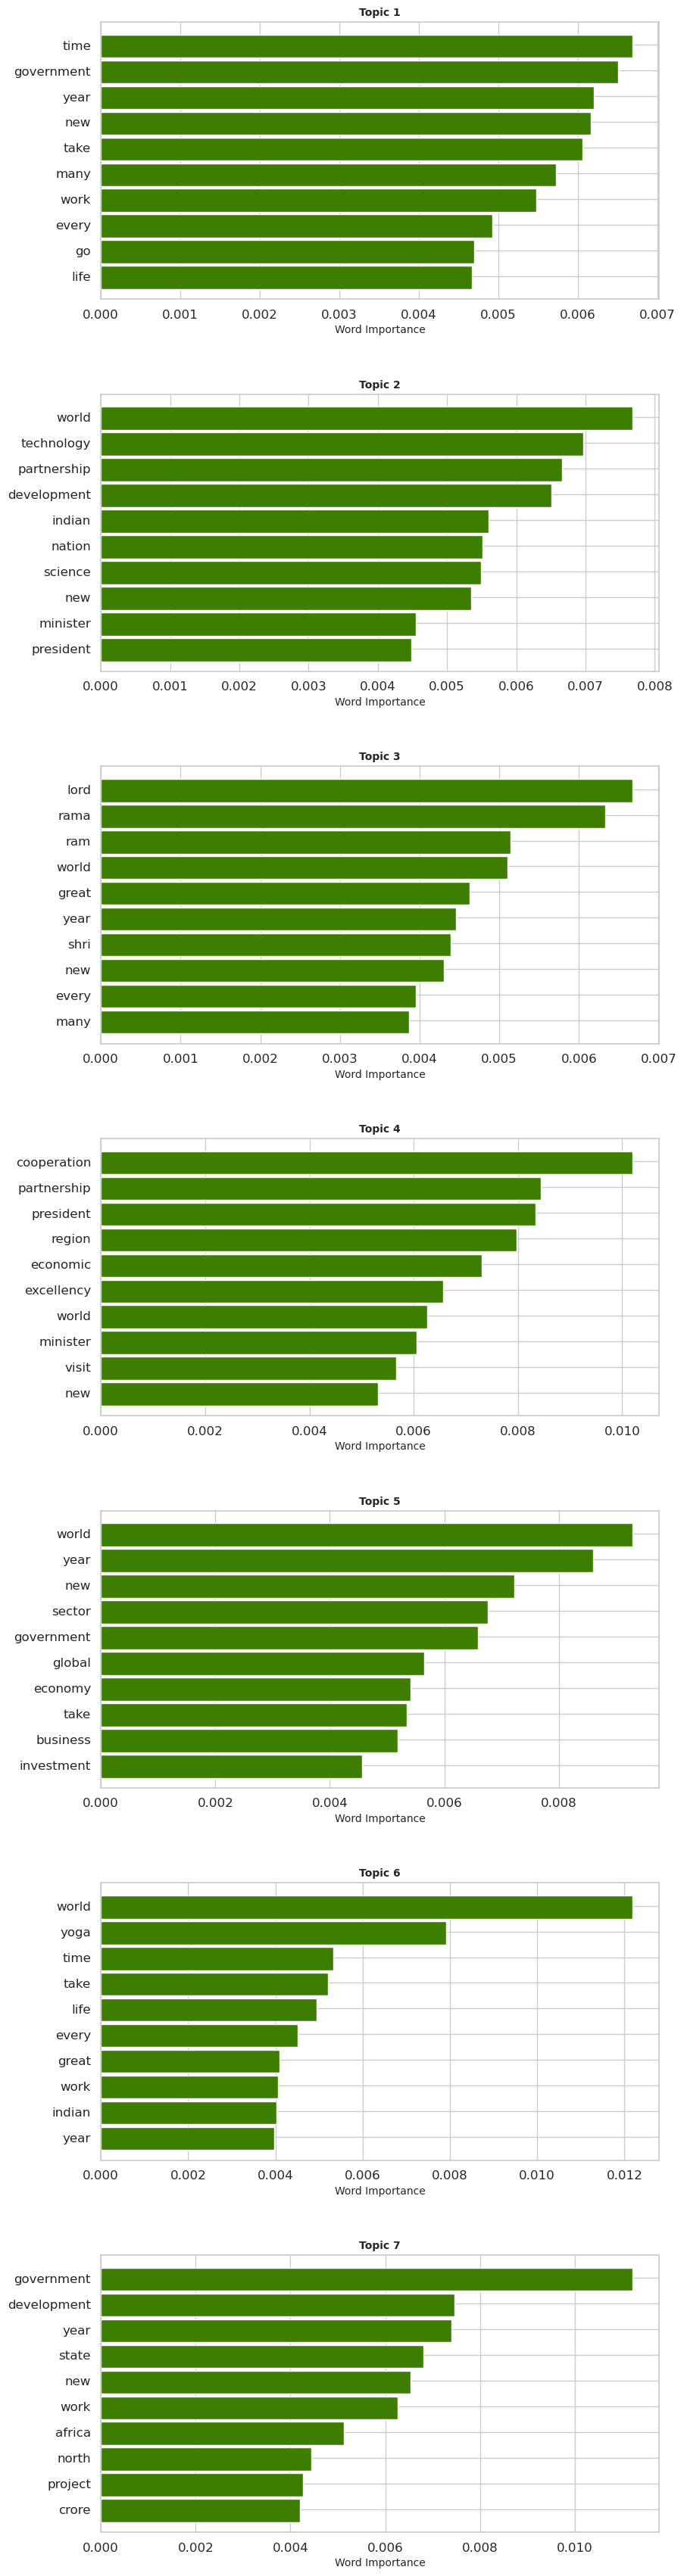

In [67]:
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(10, 5 * num_topics), dpi=100)  # Increased subplot height further

for i in range(num_topics):
    words = top_words_per_topic[i]
    word_scores = [score for _, score in lda_model.get_topic_terms(i, topn=num_words)]

    ax = axes[i]
    ax.barh(words, word_scores, color='#3D7D00')
    ax.set_title(f'Topic {i+1}', fontsize=10, fontweight='bold')
    ax.invert_yaxis()
    ax.set_xlabel('Word Importance', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=12)

    for bar in ax.patches:
        bar.set_height(bar.get_height() + 0.1)

fig.tight_layout(pad=3.5)
plt.show()

1. Topic 1: Governmental Activities
Keywords: time, government, year, new, take, many, work, every, go, life
This topic is likely about ongoing government activities and public initiatives, without delving into any specifics.

2. Topic 1: Technology and International Relations
Keywords: world, technology, partnership, development, Indian, nation, science, new, minister, presidentT
This topic is likely about India's technological partners or its advancements in technology, international partnerships, and development, suggesting a focus on national growth through technology and global cooperation.

3. Topic 3: Religious References
Keywords: lord, rama, ram, world, great, year, shri, new, every, many
This topic is likely about the building of a temple of Lord Rama in India — a contentious topic.

4. Topic 4: Diplomacy and Economic Partnerships
Keywords: cooperation, partnership, president, region, economic, excellency, world, minister, visit, new
It discusses diplomatic relations and economic partnerships, focusing on cooperation and mutual benefits within specified regions, possibly at diplomatic events or summits.

5. Topic 5: Global Economic Development
Keywords: world, year, new, sector, government, global, economy, take, business, investment
This topic centers on the broader aspects of global economics or business relationships

6. Topic 6: Cultural Practices
Keywords: world, yoga, time, take, life, every, great, work, indian, year
This topic likely talks about yoga as one of the practices that every Indian should do — a practice that the Prime Minister has stressed on.

7. Topic 7: Regional Development and Investments
Keywords: government, development, year, state, new, work, africa, north, project, crore
This topic likely relates to specific regional development projects, including infrastructure and economic development within certain states or regions, possibly including international regions like Africa.


## PART E: Results from Sentiment Analysis

For sentiment analysis of our datasets, we use textblob. Textblob is based on the natural language toolkit (NLTK) which uses up fewer computational resources, unlike Flair which is also an embeddings based model which is an alternative we played around with. TextBlob also has semantic labels that help with fine-grained analysis.

### 1. PM Modi's Speeches data

In [68]:
from textblob import TextBlob

# Function to calculate sentiment and split into polarity and subjectivity
def calculate_sentiment(text):
    blob = TextBlob(str(text))  # Ensure the text is a string
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment calculation to each tweet
speeches_df[['polarity', 'subjectivity']] = speeches_df['text'].apply(
    lambda x: pd.Series(calculate_sentiment(x))
)

# Define sentiment type based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

speeches_df['Sentiment_Type'] = speeches_df['polarity'].apply(classify_sentiment)
speeches_df

date                                              title lang  words  \
0   2020-08-30  PM’s address in the 15th Episode of ‘Mann Ki B...   en  21619   
1   2020-08-29  PM’s address at inauguration of the College an...   en  10128   
2   2020-08-27  PM’s address at seminar on Atmanirbhar Bharat ...   en   8497   
3   2020-08-15  PM’s address to the Nation from the ramparts o...   en  50260   
4   2020-08-13  PM’s address at the Launch of ‘Transparent Tax...   en  11908   
..         ...                                                ...  ...    ...   
917 2014-10-09  Text of the PM’s keynote address at the “Inves...   hi  21430   
918 2014-10-03  English rendering of text of PM’s first Mann K...   en  11169   
919 2014-10-03  Text of PM’s first Mann ki Baat to the Nation ...   hi  10312   
920 2014-10-02  Text of PM’s address during launch of ‘Swachh ...   hi  15605   
921 2014-08-15  PM’s address to the Nation from the ramparts o...   en  41373   

                                                  text  year  polarity  \
0    My dear countrymen Namaskar\nGenerally this pe...  2020  0.199217   
1    Our countrys Agriculture Minister Shri Narendr...  2020  0.145823   
2    My cabinet colleague Shri Rajnath ji Chief of ...  2020  0.138355   
3    My dear countrymen\nCongratulations and many b...  2020  0.169636   
4    The process of Structural Reforms going on in ...  2020  0.115665   
..                                                 ...   ...       ...   
917    \n                                          ...  2014  0.134573   
918  My Dear Countrymen\nToday is the holy festival...  2014  0.150949   
919    \n            \n                            ...  2014  0.000000   
920     \n                          \n         \n  ...  2014  0.108333   
921  Prime Minister Shri Narendra Modi addressed th...  2014  0.112560   

     subjectivity Sentiment_Type  
0        0.497026       Positive  
1        0.455129       Positive  
2        0.368087       Positive  
3        0.462854       Positive  
4        0.465103       Positive  
..            ...            ...  
917      0.347362       Positive  
918      0.545187       Positive  
919      0.000000        Neutral  
920      0.413333       Positive  
921      0.431742       Positive  

[922 rows x 9 columns]

The sentiment analysis for each speech has been completed. The results include two components for each speech:

- Polarity: A measure of the sentiment ranging from -1 (very negative) to 1 (very positive). A polarity close to 0 typically indicates a neutral sentiment.
- Subjectivity: A measure of how subjective or opinionated the text is, ranging from 0 (objective) to 1 (subjective).

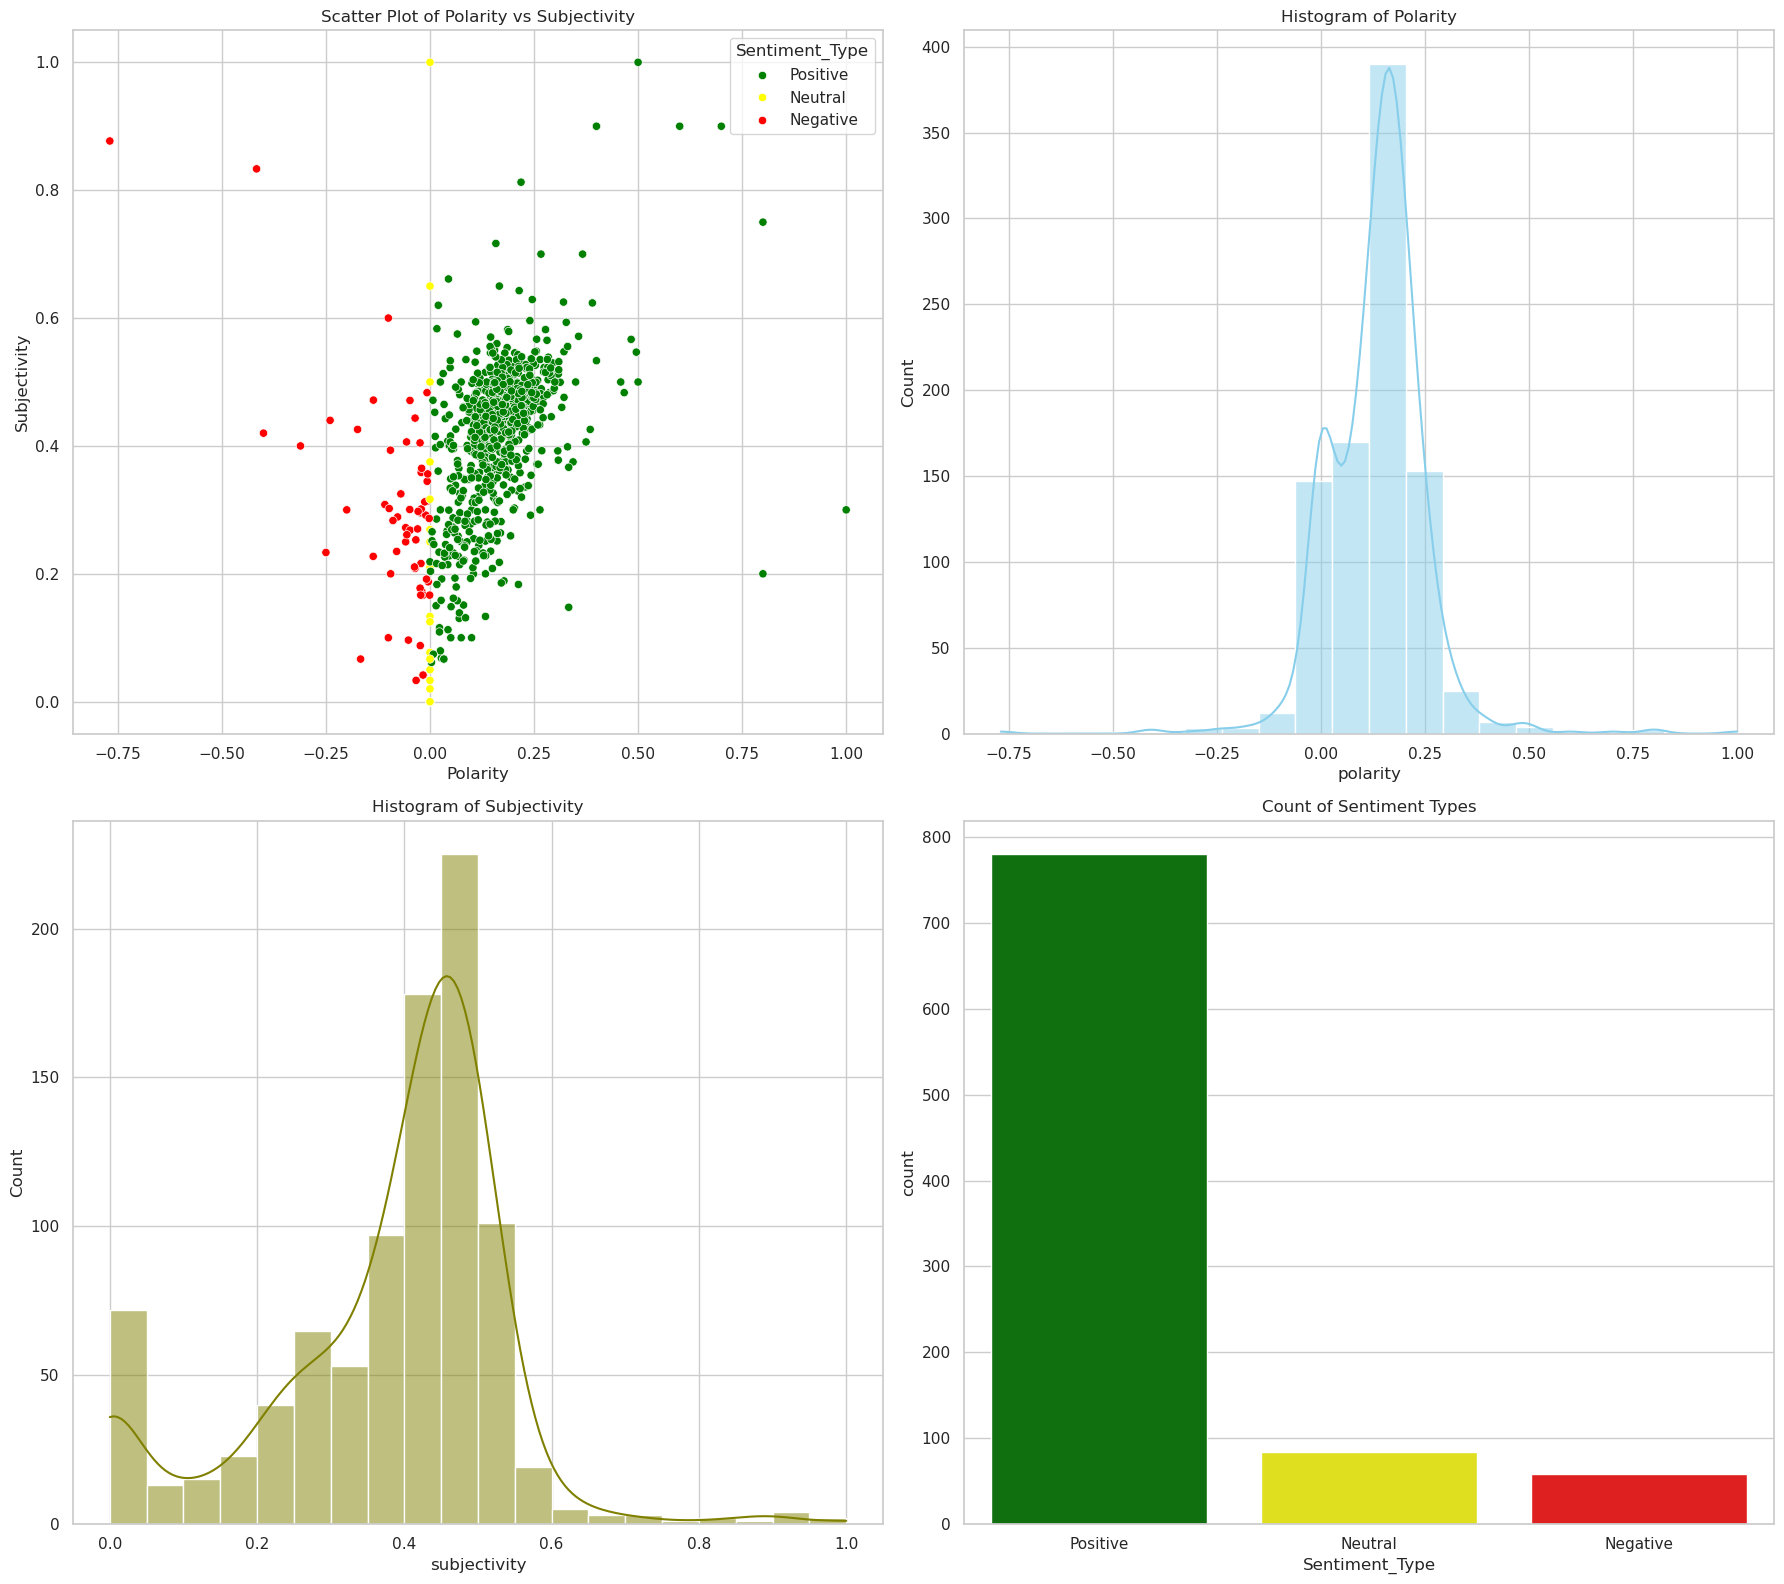

In [69]:
# Set custom colors for the sentiment types
custom_palette = {"Positive": "green", "Neutral": "yellow", "Negative": "red"}

# Set plot style
sns.set(style="whitegrid")


# Create subplots with custom color schemes
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Scatter plot of polarity vs subjectivity with custom colors
sns.scatterplot(x='polarity', y='subjectivity', hue='Sentiment_Type', data=speeches_df, ax=axes[0, 0], palette=custom_palette)
axes[0, 0].set_title('Scatter Plot of Polarity vs Subjectivity')
axes[0, 0].set_xlabel('Polarity')
axes[0, 0].set_ylabel('Subjectivity')

# Histogram of polarity
sns.histplot(speeches_df['polarity'], bins=20, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Histogram of Polarity')

# Histogram of subjectivity
sns.histplot(speeches_df['subjectivity'], bins=20, kde=True, ax=axes[1, 0], color='olive')
axes[1, 0].set_title('Histogram of Subjectivity')

# Count plot of sentiment types with custom colors
sns.countplot(x="Sentiment_Type", data=speeches_df, ax=axes[1, 1], palette=custom_palette)
axes[1, 1].set_title('Count of Sentiment Types')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


The visualizations provide several insights into the sentiment analysis of the data:

1) Scatter Plot of Polarity vs Subjectivity:
- Most speeches have positive polarity, indicating a generally positive sentiment.
- A dense cluster of points suggests a common range of polarity between 0 to 0.4 and subjectivity around 0.4 to 0.6. This could imply a consistency in the speech's tone and subjectivity level.
- Few speeches are negatively polarized, and they tend to have a lower subjectivity score, meaning even negative sentiments are presented in a more factual than opinionated manner.
- The spread of subjectivity is relatively even, not concentrating at the extremes, showing that the speeches maintain a balance between objective reporting and subjective opinion.

2) Histogram of Polarity:
- The polarity histogram shows a bell-shaped distribution centered slightly to the right of the midpoint, confirming the overall positive sentiment.
- The distribution appears to be normal with most of the data falling between 0 to 0.3, indicating that the majority of the speeches have low to moderately positive sentiment.

3) Histogram of Subjectivity:
- The subjectivity histogram shows a large peak around 0.5, suggesting many speeches have a balanced level of opinion and fact.
- The distribution of subjectivity scores is more skewed to the right, with a long tail extending towards 1, which indicates that there are fewer highly subjective speeches.

4) Count of Sentiment Types:
- A vast majority of speeches are categorized as Positive, which is indicated by the large green bar.
- There are some Neutral speeches, as indicated by the yellow bar, but they are significantly fewer than the Positive ones.
- The number of Negative speeches is the least, shown by the small red bar.

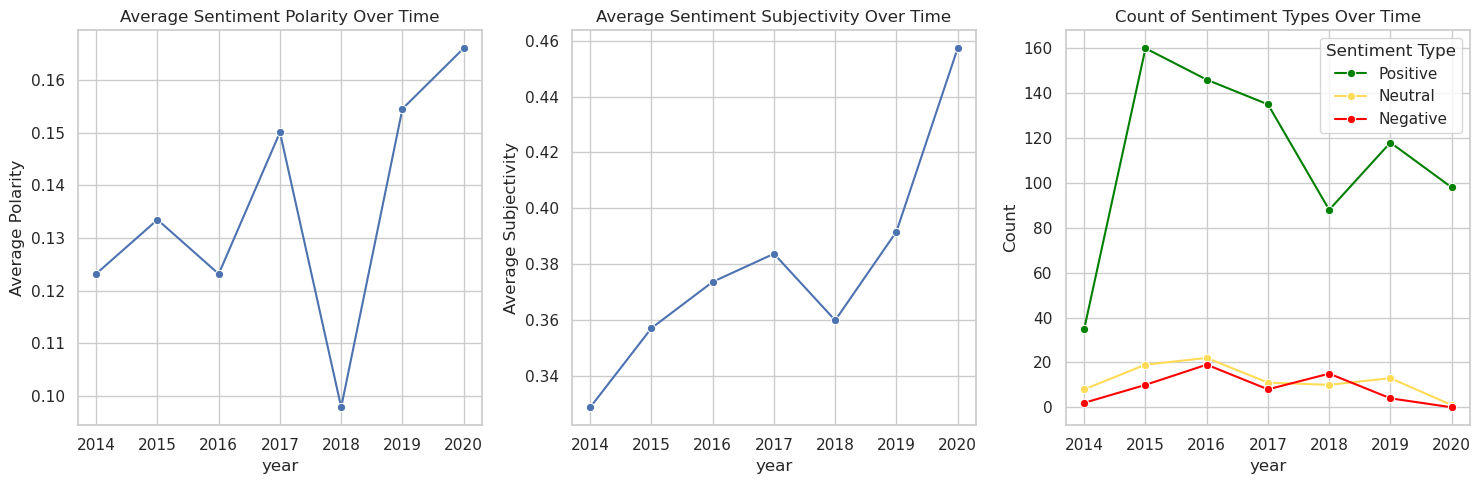

In [70]:
# Define custom colors for each sentiment type
sentiment_colors = {'Positive': 'green', 'Neutral': '#FFDB58', 'Negative': 'red'}

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Aggregate data by year for average polarity and subjectivity
annual_sentiment = speeches_df.groupby(['year']).agg(
    avg_polarity=('polarity', 'mean'),
    avg_subjectivity=('subjectivity', 'mean')
).reset_index()

# Plot average polarity over time
sns.lineplot(data=annual_sentiment, x='year', y='avg_polarity', marker='o', ax=axes[0])
axes[0].set_title('Average Sentiment Polarity Over Time')
axes[0].set_ylabel('Average Polarity')

# Plot average subjectivity over time
sns.lineplot(data=annual_sentiment, x='year', y='avg_subjectivity', marker='o', ax=axes[1])
axes[1].set_title('Average Sentiment Subjectivity Over Time')
axes[1].set_ylabel('Average Subjectivity')

# Count of sentiment types by year
count_sentiment = speeches_df.groupby(['year', 'Sentiment_Type']).size().unstack(fill_value=0).reset_index()

# Plot count of sentiments over time
for sentiment in ['Positive', 'Neutral', 'Negative']:
    sns.lineplot(data=count_sentiment, x='year', y=sentiment, marker='o', ax=axes[2], label=sentiment, color=sentiment_colors[sentiment] )
axes[2].set_title('Count of Sentiment Types Over Time')
axes[2].set_ylabel('Count')
axes[2].legend(title='Sentiment Type')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


We find that the average sentiment polarity and sentiment subjectivity both follow an upward trend over time. Further, there are many more positive sentiment types by count than neutral and negative. 

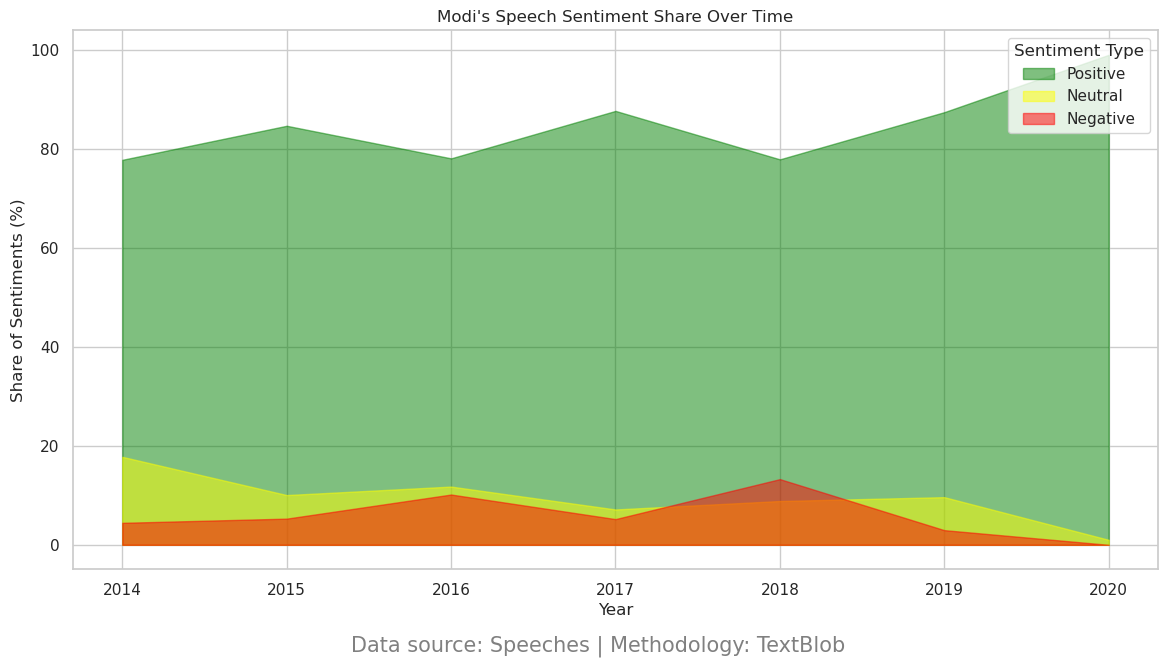

In [71]:
# Calculate the total counts by year
count_sentiment = speeches_df.groupby(['year', 'Sentiment_Type']).size().unstack(fill_value=0).reset_index()

# Calculate the total tweets per year
count_sentiment['total_tweets'] = count_sentiment[['Positive', 'Neutral', 'Negative']].sum(axis=1)

# Calculate the share of each sentiment type
count_sentiment['Positive_share'] = count_sentiment['Positive'] / count_sentiment['total_tweets']
count_sentiment['Neutral_share'] = count_sentiment['Neutral'] / count_sentiment['total_tweets']
count_sentiment['Negative_share'] = count_sentiment['Negative'] / count_sentiment['total_tweets']

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define custom colors for each sentiment type
sentiment_colors = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}

# Plot each sentiment type as a stacked area plot
for sentiment in ['Positive', 'Neutral', 'Negative']:
    ax.fill_between(count_sentiment['year'],
                    count_sentiment[sentiment + '_share'] * 100,
                    label=sentiment,
                    color=sentiment_colors[sentiment],
                    alpha=0.5)

# Configure the plot
ax.set_title("Modi's Speech Sentiment Share Over Time")
ax.set_xlabel('Year')
ax.set_ylabel('Share of Sentiments (%)')
ax.legend(title='Sentiment Type')

# Add a note at the bottom of the plot
fig.text(0.5,0.0001, 'Data source: Speeches | Methodology: TextBlob', ha='center', va='center', fontsize=15, color='gray')

# Show the plot
plt.show()

Finally, a majority share of the PM's speeches were positive with a smaller share being negative or neutral. 

### 2. Tweets data

In [72]:
tweets_df = pd.read_csv('3. Political_party_tweets/final_clean_tweets.csv')

In [73]:
# Function to calculate sentiment and split into polarity and subjectivity
def calculate_sentiment(text):
    blob = TextBlob(str(text))  # Ensure the text is a string
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment calculation to each tweet
tweets_df[['polarity', 'subjectivity']] = tweets_df['text'].apply(
    lambda x: pd.Series(calculate_sentiment(x))
)

# Define sentiment type based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

tweets_df['Sentiment_Type'] = tweets_df['polarity'].apply(classify_sentiment)

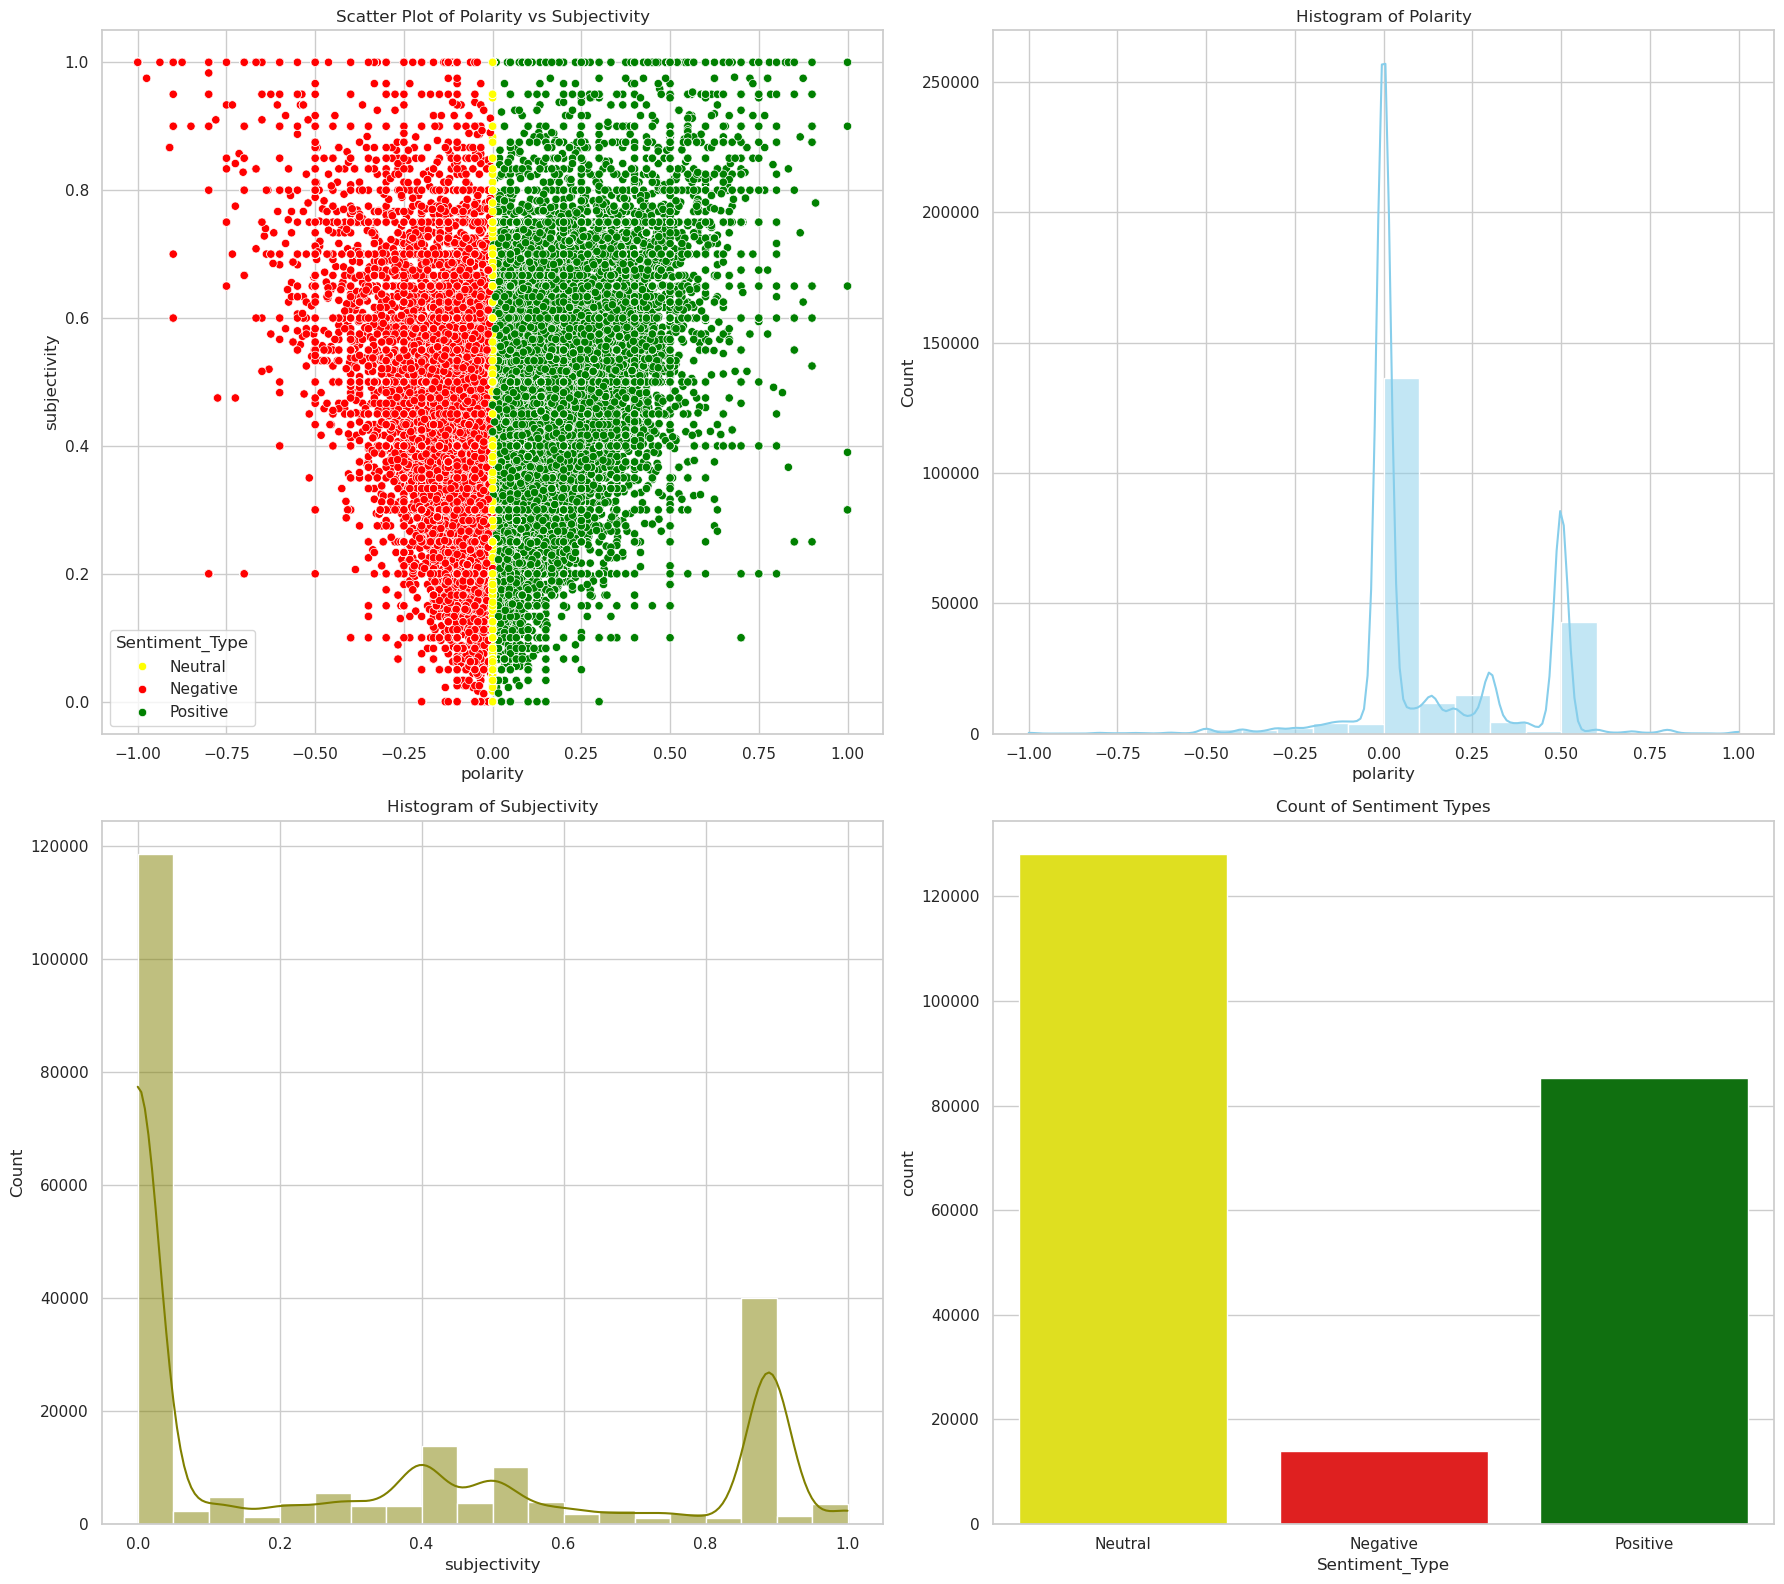

In [74]:
# Set custom colors for the sentiment types
custom_palette = {"Positive": "green", "Neutral": "yellow", "Negative": "red"}

# Set plot style
sns.set(style="whitegrid")

# Create subplots with custom color schemes
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Scatter plot of polarity vs subjectivity with custom colors
sns.scatterplot(x='polarity', y='subjectivity', hue='Sentiment_Type', data=tweets_df, ax=axes[0, 0], palette=custom_palette)
axes[0, 0].set_title('Scatter Plot of Polarity vs Subjectivity')

# Histogram of polarity
sns.histplot(tweets_df['polarity'], bins=20, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Histogram of Polarity')

# Histogram of subjectivity
sns.histplot(tweets_df['subjectivity'], bins=20, kde=True, ax=axes[1, 0], color='olive')
axes[1, 0].set_title('Histogram of Subjectivity')

# Count plot of sentiment types with custom colors
sns.countplot(x="Sentiment_Type", data=tweets_df, ax=axes[1, 1], palette=custom_palette)
axes[1, 1].set_title('Count of Sentiment Types')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

These plots collectively offer a comprehensive view of the sentiment landscape across the speeches, highlighting both the emotional tone and the level of personal opinion in the content

- Scatter Plot of Polarity vs Subjectivity: This plot shows each speech's polarity against its subjectivity. Different colors indicate whether the sentiment is Positive, Neutral, or Negative. This helps in observing how subjective or objective the speeches are in relation to their sentiment.
- Histogram of Polarity: This histogram provides a distribution of polarity scores across all speeches, showing how many speeches tend towards positive, neutral, or negative sentiments.
- Histogram of Subjectivity: Similar to the polarity histogram, this one shows the distribution of subjectivity scores, indicating how many speeches are more factual versus opinion-based.
- Count of Sentiment Types: This count plot categorizes each speech as Positive, Neutral, or Negative based on the polarity score. It gives a quick overview of the overall sentiment trends in the speeches.


In [75]:
# Convert 'datetime' column to datetime type
tweets_df['datetime'] = pd.to_datetime(tweets_df['datetime'])

# Extract year, month, and quarter from the datetime
tweets_df['year'] = tweets_df['datetime'].dt.year
tweets_df['month'] = tweets_df['datetime'].dt.month
tweets_df['quarter'] = tweets_df['datetime'].dt.to_period('Q')  # This creates a quarterly period based on date

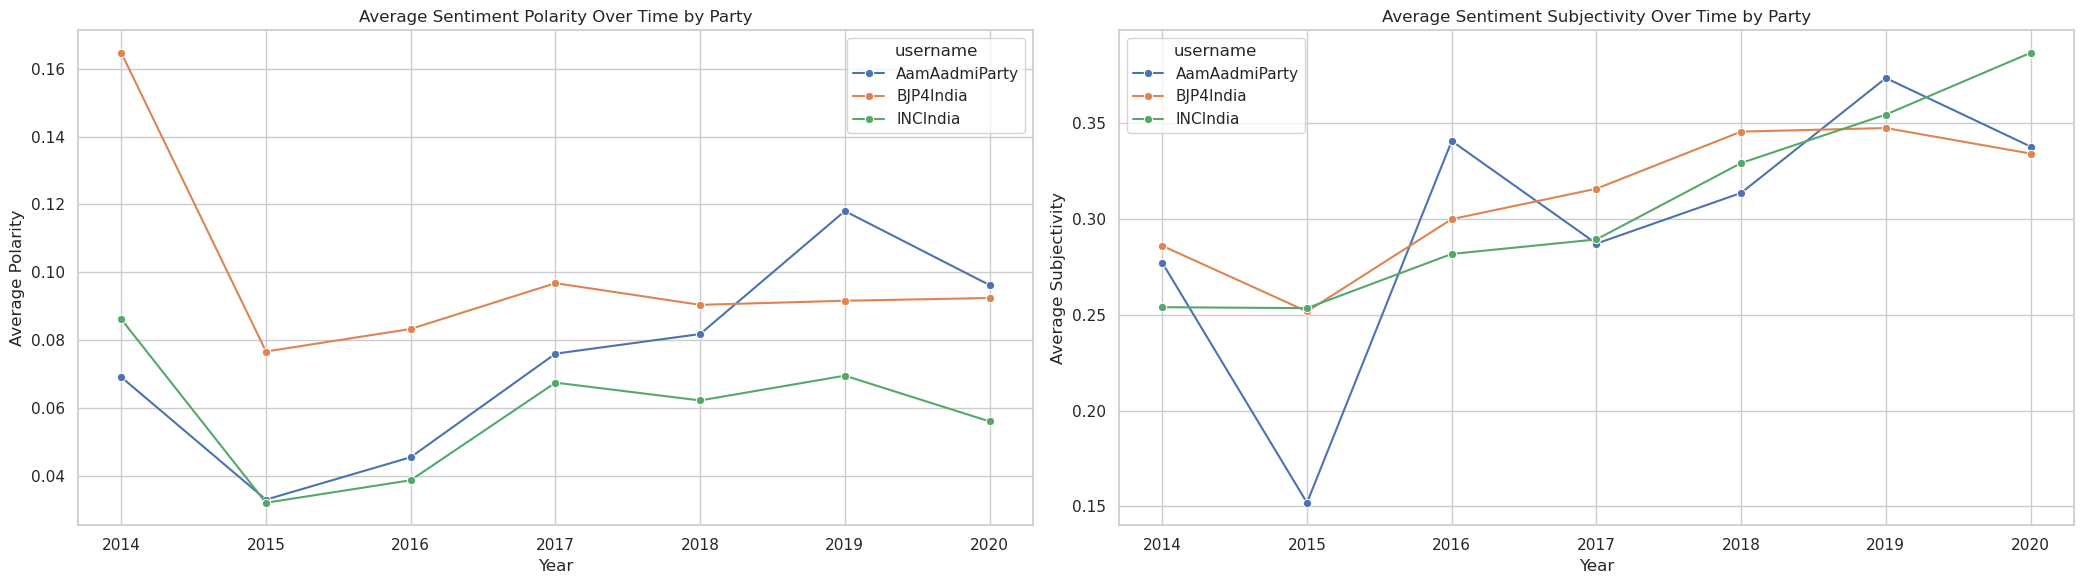

In [76]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(21, 6))  # Adjusted for a horizontal layout

# Aggregate data by year and username for average polarity and subjectivity
annual_sentiment = tweets_df.groupby(['year', 'username']).agg(
    avg_polarity=('polarity', 'mean'),
    avg_subjectivity=('subjectivity', 'mean')
).reset_index()

# Plot average polarity over time by party
sns.lineplot(data=annual_sentiment, x='year', y='avg_polarity', hue='username', marker='o', ax=axes[0])
axes[0].set_title('Average Sentiment Polarity Over Time by Party')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Polarity')

# Plot average subjectivity over time by party
sns.lineplot(data=annual_sentiment, x='year', y='avg_subjectivity', hue='username', marker='o', ax=axes[1])
axes[1].set_title('Average Sentiment Subjectivity Over Time by Party')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Subjectivity')



# Adjust layout and show plot
plt.tight_layout()
plt.show()

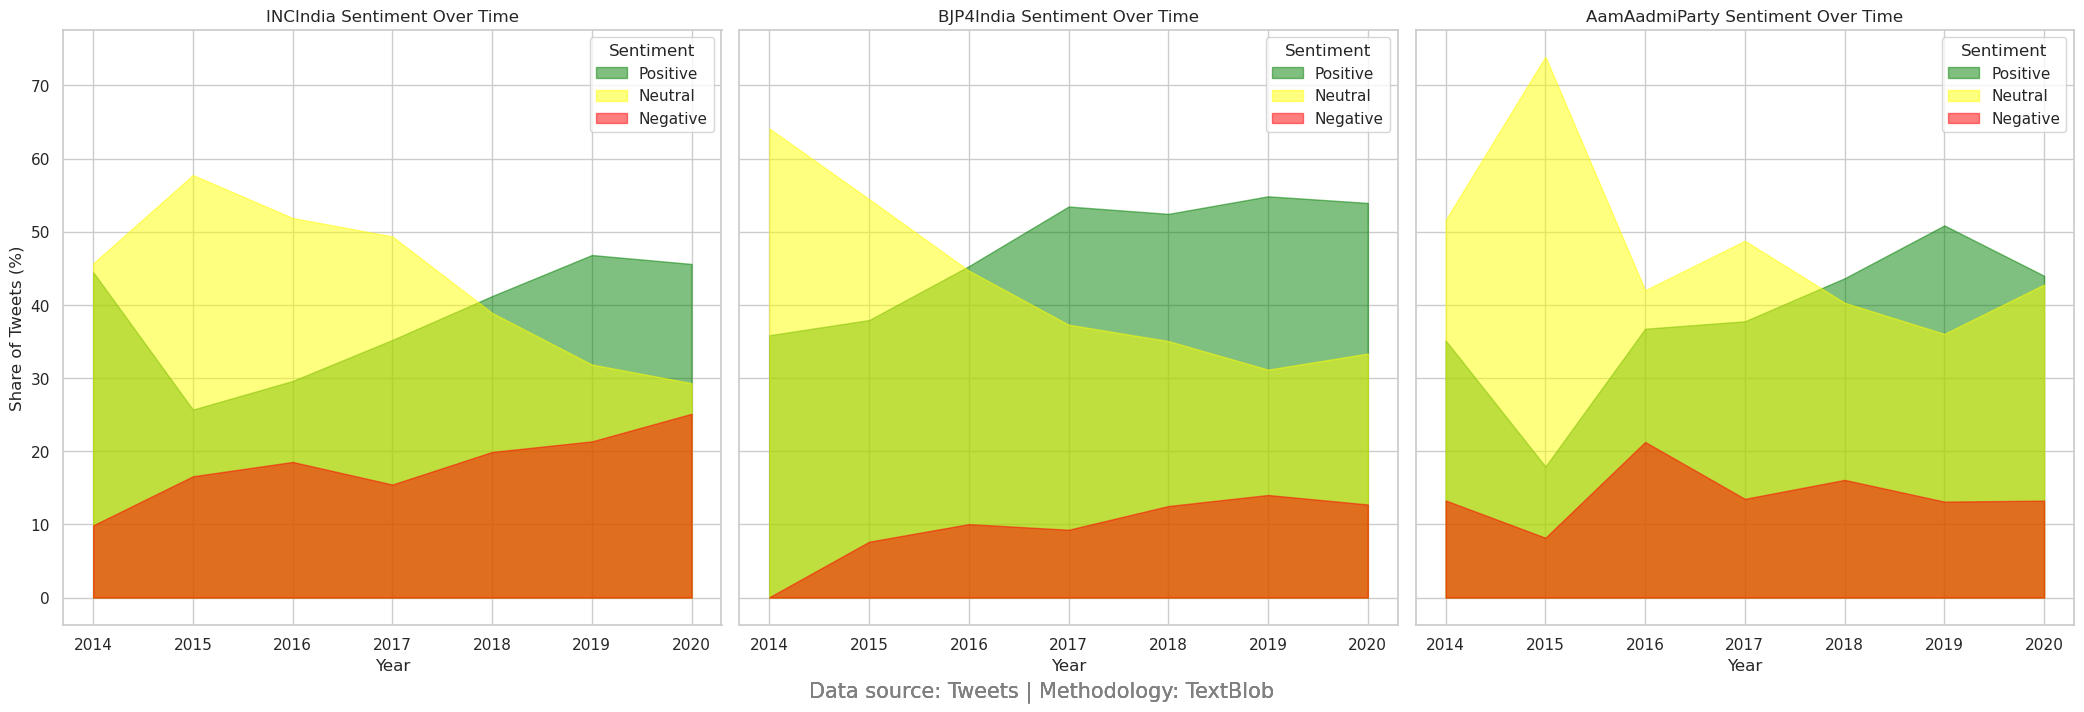

In [77]:
# Group data by year and username, and pivot sentiment types into columns
sentiment_counts = tweets_df.groupby(['year', 'username', 'Sentiment_Type']).size().unstack(fill_value=0).reset_index()

# Calculate the total number of tweets per year per party
sentiment_counts['total_tweets'] = sentiment_counts[['Positive', 'Neutral', 'Negative']].sum(axis=1)

# Calculate the share of each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    sentiment_counts[f'{sentiment}_share'] = sentiment_counts[sentiment] / sentiment_counts['total_tweets']

# Set up the figure with 3 horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

# Define custom colors for each sentiment type
sentiment_colors = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}

# Define party names for subplot titles
parties = ['INCIndia', 'BJP4India', 'AamAadmiParty']

# Loop over each subplot axis and party
for ax, party in zip(axes, parties):
    # Select the data for the current party
    data = sentiment_counts[sentiment_counts['username'] == party]

    # Plot each sentiment type as a stacked area plot
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        ax.fill_between(data['year'], data[f'{sentiment}_share'] * 100,
                        label=sentiment, color=sentiment_colors[sentiment], alpha=0.5)

    # Set titles and labels
    ax.set_title(f'{party} Sentiment Over Time')
    ax.set_xlabel('Year')
    if ax is axes[0]:  # Only add y-label to the first subplot for cleanliness
        ax.set_ylabel('Share of Tweets (%)')

    # Add legend to each subplot
    ax.legend(title='Sentiment')

    # Add a note at the bottom of the plot
    fig.text(0.5,0.0001, 'Data source: Tweets | Methodology: TextBlob', ha='center', va='center', fontsize=15, color='gray')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

These plots show that INC and BJP show fluctuating sentiment, with INC peaking positively in 2015 and BJP in 2019, both followed by increases in negative sentiment. Aam Aadmi Party exhibits a more variable pattern with shifts between positive and negative sentiments.​

### 3. Parliamentary Questions data

In [79]:
ques_df = pd.read_csv('1. Parliamentary_questions/TCPD_QH.tsv', delimiter='\t', encoding='utf-8')

In [80]:
# Assuming 'date' is the column name that contains date information in the original dataset
ques_df['date'] = pd.to_datetime(ques_df['date'])

# Extract year, month, and quarter from the date
ques_df['year'] = ques_df['date'].dt.year
ques_df['month'] = ques_df['date'].dt.month
ques_df['quarter'] = ques_df['date'].dt.to_period('Q')

# Filter the dataframe for questions from 2014 onwards
ques_df = ques_df[(ques_df['year'] >= 2014) ]

# Clean up the 'party' field by retaining only the first party listed in cases of multiple entries
ques_df['party'] = ques_df['party'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x)

# Clean up the 'gender' field by retaining only the first gender listed in cases of multiple entries
ques_df['gender'] = ques_df['gender'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x)

In [81]:
# Check unique party names
print(ques_df['party'].unique())

# Filter for specific parties
selected_parties = ['BJP', 'INC', 'AAAP']  # Adjust party names based on actual data
ques_df = ques_df[ques_df['party'].isin(selected_parties)]

['BJP' 'ADMK' 'AITC' 'YSRCP' 'CPM' 'TDP' 'SWP' 'TRS' 'BJD' 'INC' 'KEC(M)'
 'RSP' 'SDF' 'JMM' 'AIUDF' 'AIMIM' 'CPI' 'SHS' 'LJP' 'IND' 'NCP' 'JD(U)'
 'SP' 'PMK' 'AAAP' 'RJD' 'JD(S)' 'SAD' 'INLD' 'IUML' 'BLSP' 'Nominated'
 'NPP' 'AD' 'NC' 'NPF' 'NPEP' 'JKPDP' 'SamSP' 'AINRC' 'DMK' 'BSP' 'MDMK'
 'AIFB' 'HJC' 'RLD' 'JKN' 'BVA' 'MUL' 'NDPP']


In [82]:

# Function to calculate sentiment
def calculate_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment calculation to each question
ques_df[['polarity', 'subjectivity']] = ques_df['question_text'].apply(
    lambda x: pd.Series(calculate_sentiment(x))
)

# Define sentiment type based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

ques_df['Sentiment_Type'] = ques_df['polarity'].apply(classify_sentiment)

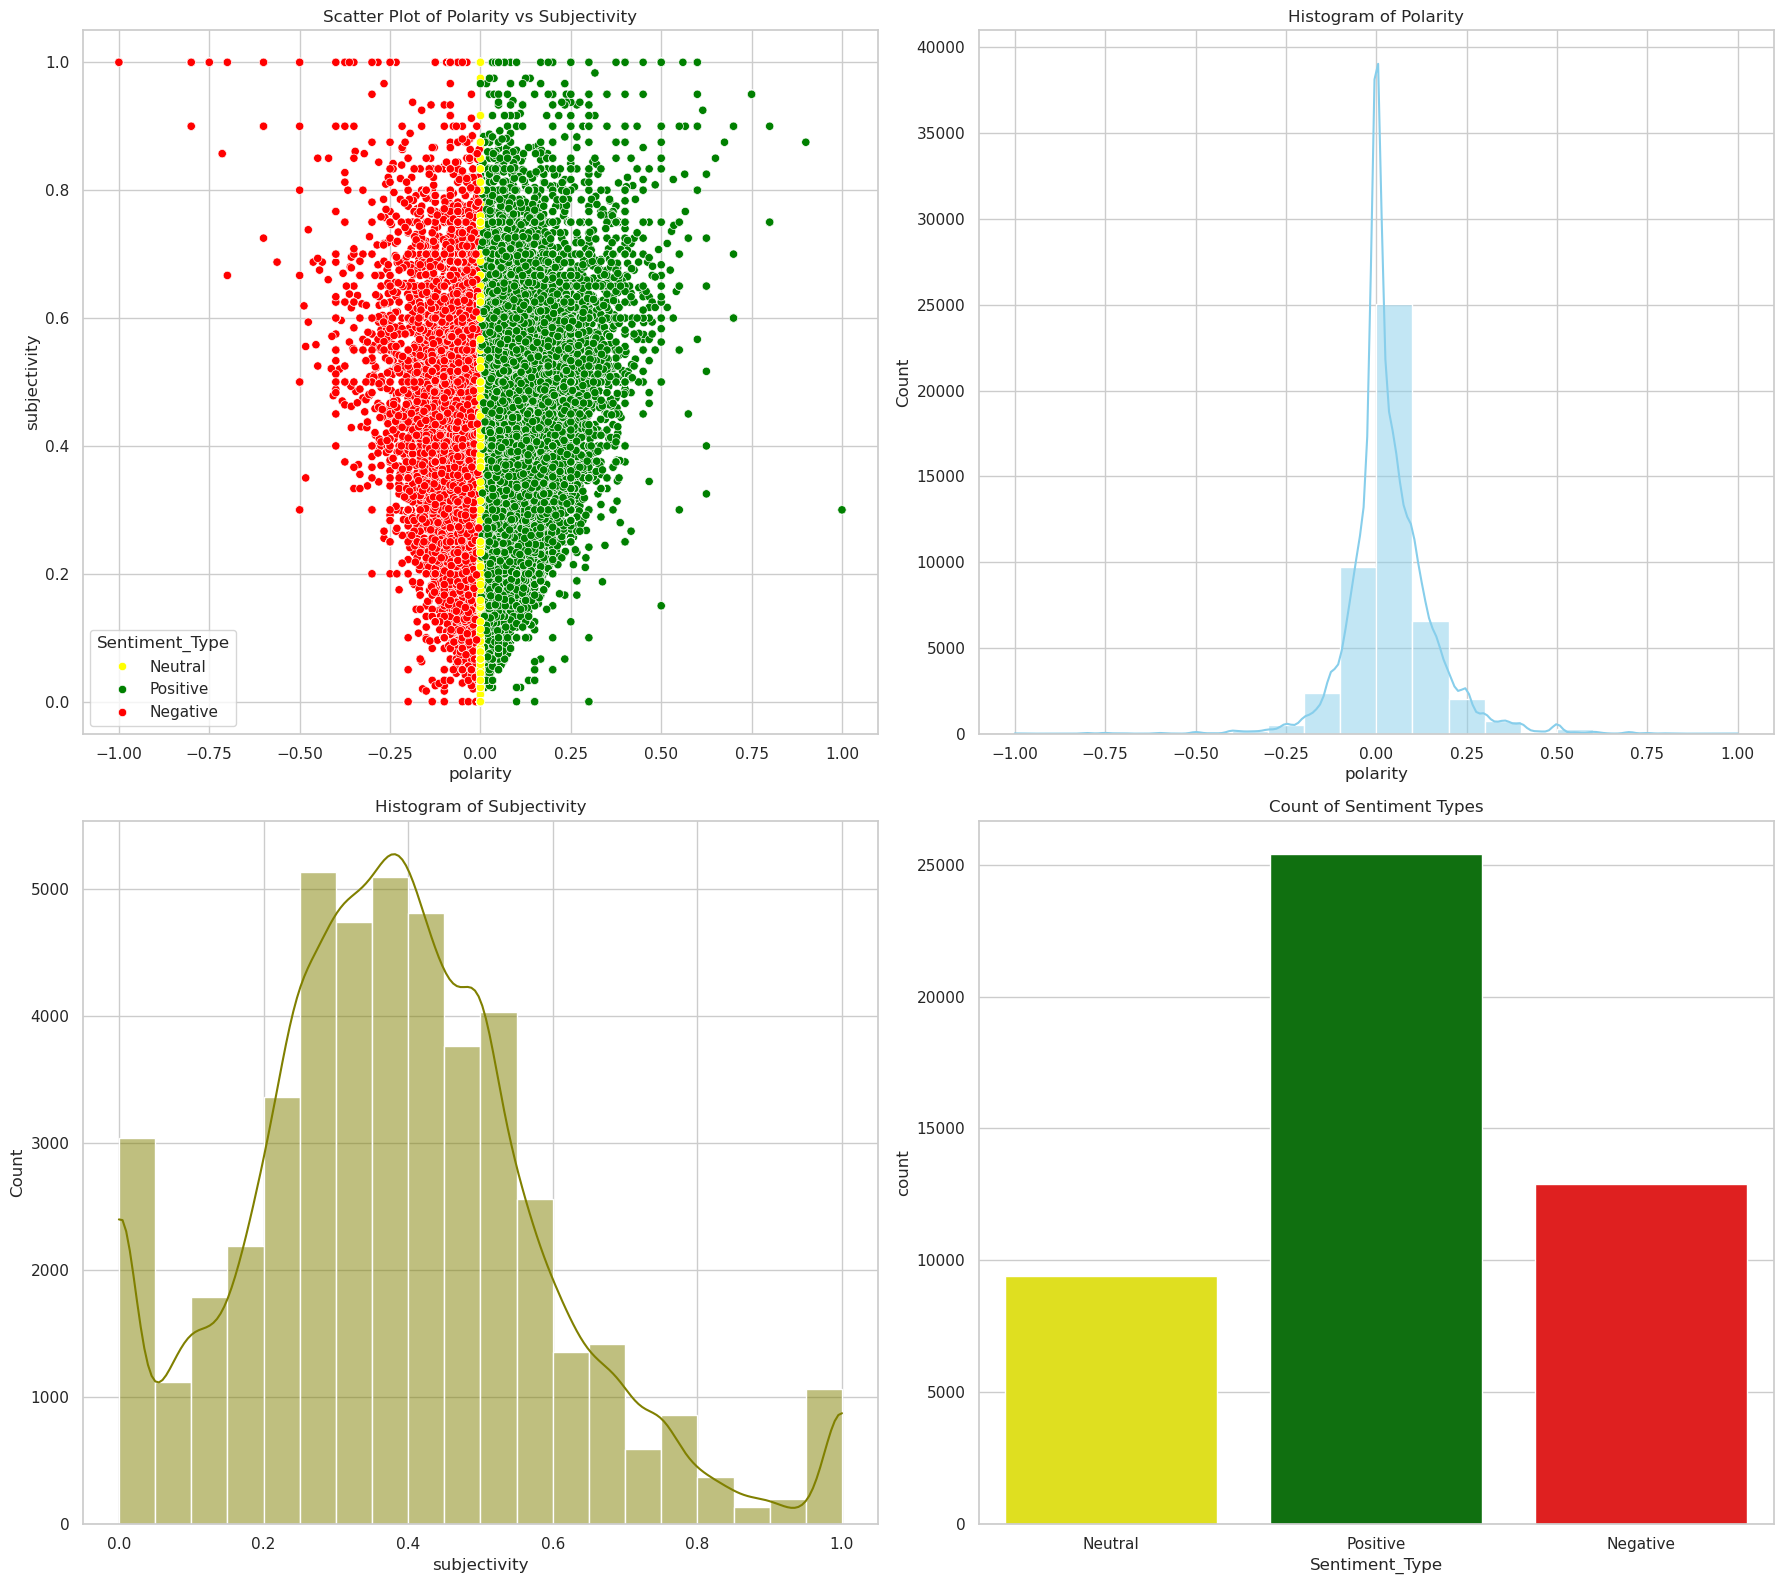

In [83]:
# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Scatter plot of polarity vs subjectivity
sns.scatterplot(x='polarity', y='subjectivity', hue='Sentiment_Type', data=ques_df, ax=axes[0, 0], palette={'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'})
axes[0, 0].set_title('Scatter Plot of Polarity vs Subjectivity')

# Histogram of polarity
sns.histplot(ques_df['polarity'], bins=20, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Histogram of Polarity')

# Histogram of subjectivity
sns.histplot(ques_df['subjectivity'], bins=20, kde=True, ax=axes[1, 0], color='olive')
axes[1, 0].set_title('Histogram of Subjectivity')

# Count plot of sentiment types
sns.countplot(x="Sentiment_Type", data=ques_df, ax=axes[1, 1], palette={'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'})
axes[1, 1].set_title('Count of Sentiment Types')

plt.tight_layout()
plt.show()

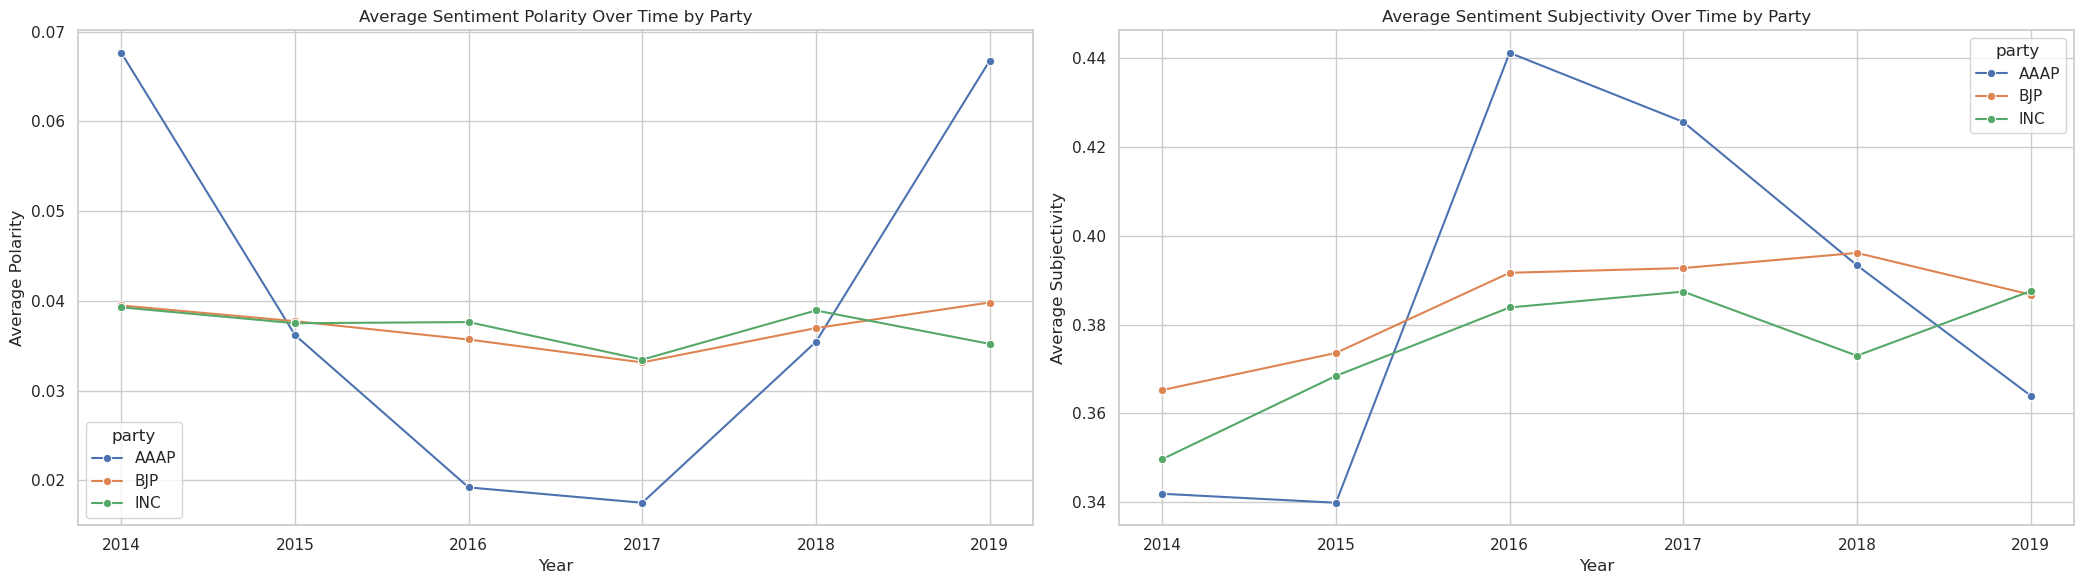

In [84]:
# Aggregate data by year and party for average polarity and subjectivity
annual_sentiment = ques_df.groupby(['year', 'party']).agg(
    avg_polarity=('polarity', 'mean'),
    avg_subjectivity=('subjectivity', 'mean')
).reset_index()

# Set up the figure and axes for line plots
fig, axes = plt.subplots(1, 2, figsize=(21, 6))

# Plot average polarity over time by party
sns.lineplot(data=annual_sentiment, x='year', y='avg_polarity', hue='party', marker='o', ax=axes[0])
axes[0].set_title('Average Sentiment Polarity Over Time by Party')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Polarity')

# Plot average subjectivity over time by party
sns.lineplot(data=annual_sentiment, x='year', y='avg_subjectivity', hue='party', marker='o', ax=axes[1])
axes[1].set_title('Average Sentiment Subjectivity Over Time by Party')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Subjectivity')

plt.tight_layout()
plt.show()

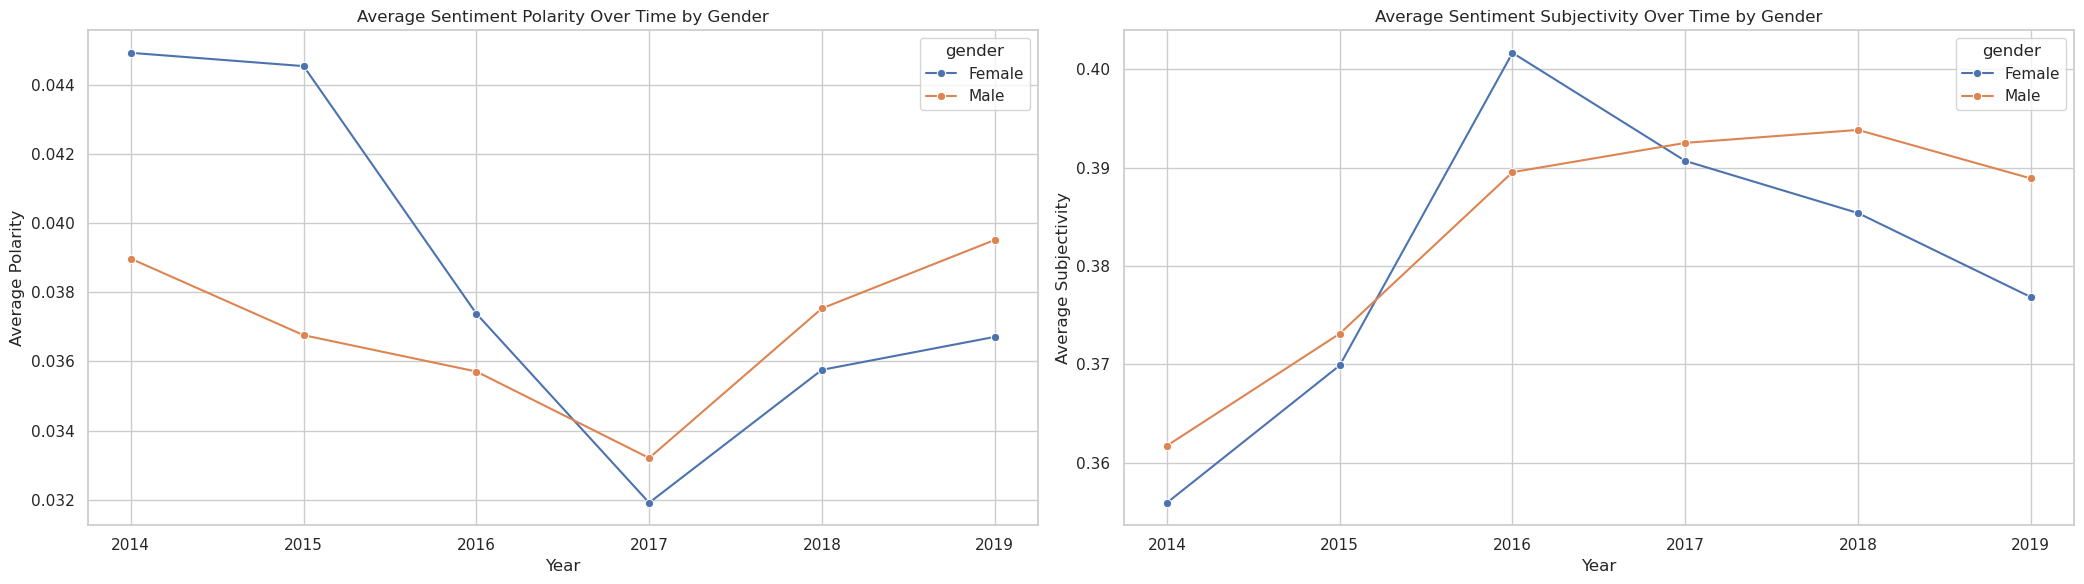

In [85]:
# Aggregate data by year and party for average polarity and subjectivity
annual_sentiment_gender = ques_df.groupby(['year', 'gender']).agg(
    avg_polarity=('polarity', 'mean'),
    avg_subjectivity=('subjectivity', 'mean')
).reset_index()

# Set up the figure and axes for line plots
fig, axes = plt.subplots(1, 2, figsize=(21, 6))

# Plot average polarity over time by party
sns.lineplot(data=annual_sentiment_gender, x='year', y='avg_polarity', hue='gender', marker='o', ax=axes[0])
axes[0].set_title('Average Sentiment Polarity Over Time by Gender')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Polarity')

# Plot average subjectivity over time by party
sns.lineplot(data=annual_sentiment_gender, x='year', y='avg_subjectivity', hue='gender', marker='o', ax=axes[1])
axes[1].set_title('Average Sentiment Subjectivity Over Time by Gender')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Subjectivity')

plt.tight_layout()
plt.show()

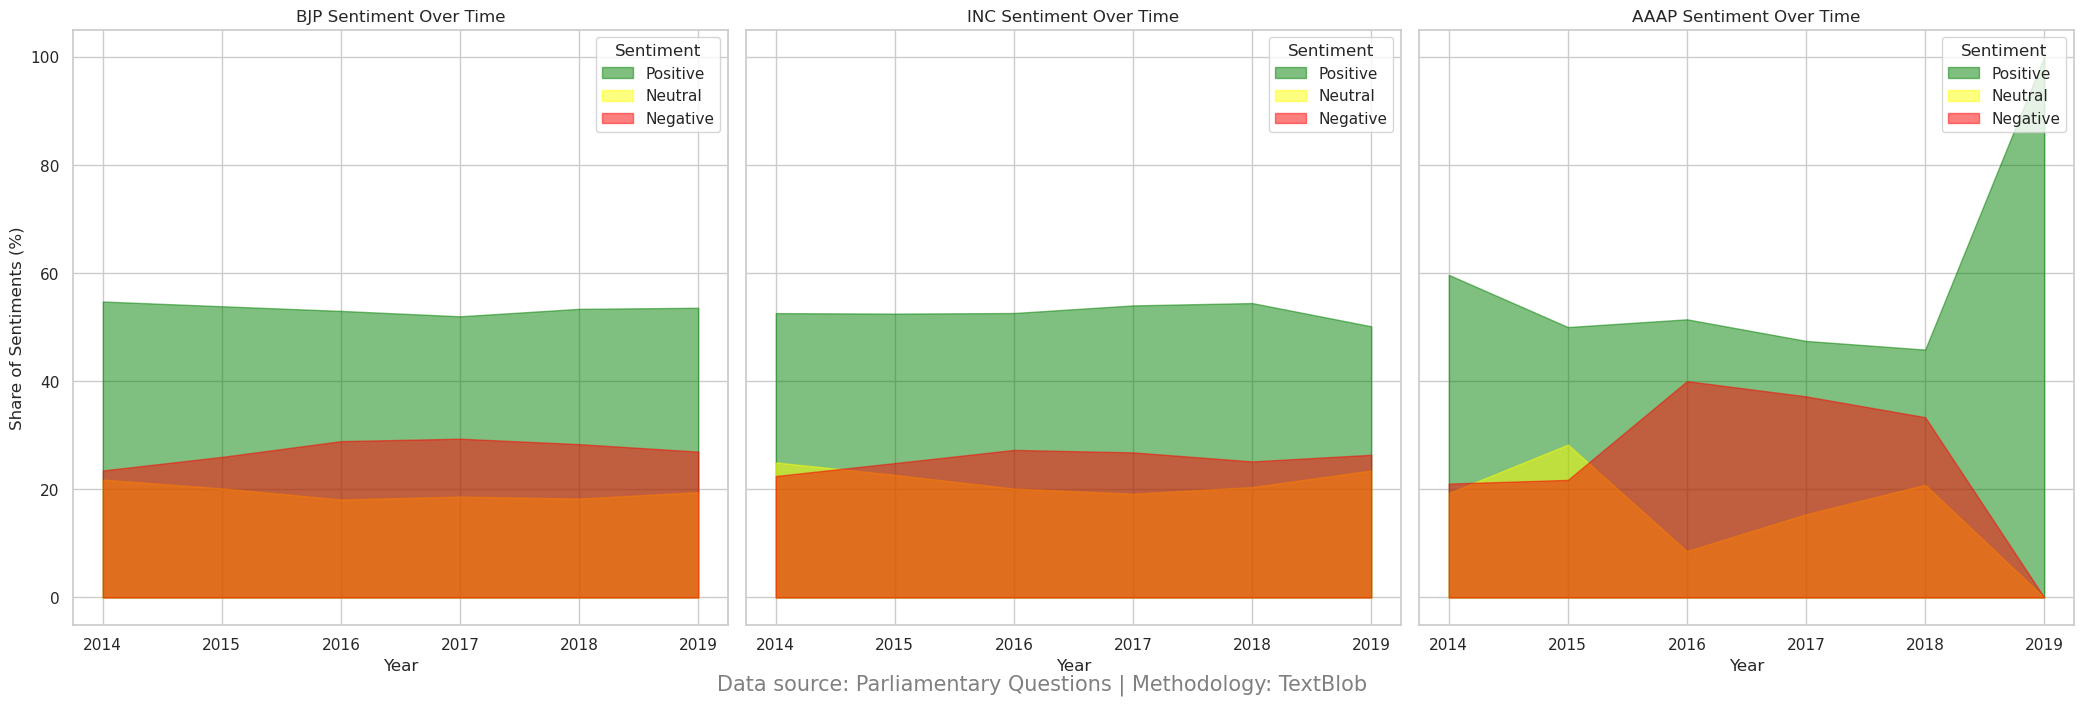

In [86]:
# Group data by year and party, and pivot sentiment types into columns
sentiment_counts = ques_df.groupby(['year', 'party', 'Sentiment_Type']).size().unstack(fill_value=0).reset_index()

# Calculate the total number of questions per year per party
sentiment_counts['total_questions'] = sentiment_counts[['Positive', 'Neutral', 'Negative']].sum(axis=1)

# Calculate the share of each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    sentiment_counts[f'{sentiment}_share'] = sentiment_counts[sentiment] / sentiment_counts['total_questions']


# Define custom colors for each sentiment type
sentiment_colors = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}

# Set up the figure with horizontal subplots for selected parties
parties = ['BJP', 'INC', 'AAAP']  # Ensure these are the correct party names from your dataset
fig, axes = plt.subplots(1, len(parties), figsize=(21, 7), sharey=True)

for ax, party in zip(axes, parties):
    # Filter data for the current party
    party_data = sentiment_counts[sentiment_counts['party'] == party]

    # Plot each sentiment type as a stacked area plot
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        ax.fill_between(party_data['year'], party_data[f'{sentiment}_share'] * 100,
                        label=sentiment, color=sentiment_colors[sentiment], alpha=0.5)

    # Set titles and labels
    ax.set_title(f'{party} Sentiment Over Time')
    ax.set_xlabel('Year')
    if ax == axes[0]:
        ax.set_ylabel('Share of Sentiments (%)')

    # Add legend to each subplot
    ax.legend(title='Sentiment')

# Add a note at the bottom of the plot
fig.text(0.5, 0.01, 'Data source: Parliamentary Questions | Methodology: TextBlob', ha='center', va='center', fontsize=15, color='gray')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [87]:
# Group data by year, party, gender, and pivot sentiment types into columns
gender_sentiment_counts = ques_df.groupby(['year', 'party', 'gender', 'Sentiment_Type']).size().unstack(fill_value=0).reset_index()

# Calculate the total number of questions per year per party per gender
gender_sentiment_counts['total_questions'] = gender_sentiment_counts[['Positive', 'Neutral', 'Negative']].sum(axis=1)

# Calculate the share of each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    gender_sentiment_counts[f'{sentiment}_share'] = gender_sentiment_counts[sentiment] / gender_sentiment_counts['total_questions']

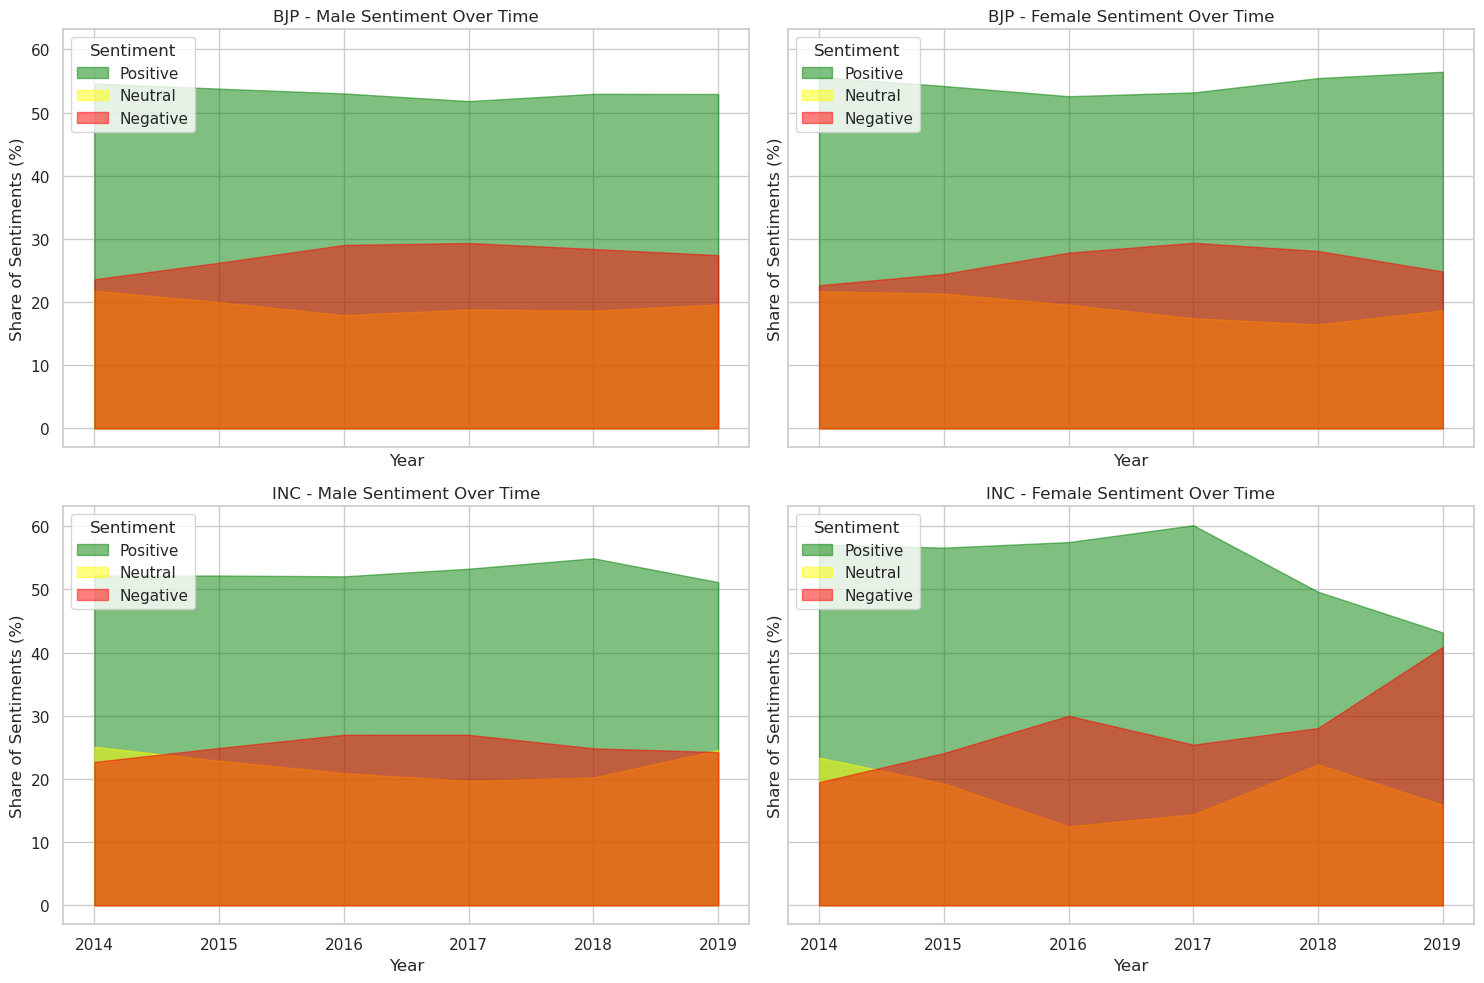

In [88]:
# Define custom colors for each sentiment type
sentiment_colors = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}

# Parties and genders you are interested in
parties = ['BJP', 'INC'] #filtering out AAAP since there is no data on female
genders = ['Male', 'Female']

# Create subplots: 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)  # Adjust size as needed

# Flatten axes array to make it easier to iterate
axes = axes.flatten()

# Index for axes for plotting
ax_index = 0

for party in parties:
    for gender in genders:
        ax = axes[ax_index]
        # Filter data for the current party and gender
        data = gender_sentiment_counts[(gender_sentiment_counts['party'] == party) & (gender_sentiment_counts['gender'] == gender)]

        # Check if data is empty, continue to next if so
        if data.empty:
            ax_index += 1
            continue

        # Plot each sentiment type as a stacked area plot
        for sentiment, color in sentiment_colors.items():
            ax.fill_between(data['year'], data[f'{sentiment}_share'] * 100,
                            label=f'{sentiment}', color=color, alpha=0.5)

        ax.set_title(f'{party} - {gender} Sentiment Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Share of Sentiments (%)')
        ax.legend(title='Sentiment', loc='upper left')  # Adjust legend location as needed

        # Increment the index for the next plot
        ax_index += 1

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The visualizations provide several insights into the sentiment analysis of the data:

1) Scatter Plot of Polarity vs Subjectivity:
- Most speeches have positive polarity, indicating a generally positive sentiment.
- A dense cluster of points suggests a common range of polarity between 0 to 0.4 and subjectivity around 0.4 to 0.6. This could imply a consistency in the speech's tone and subjectivity level.
- Few speeches are negatively polarized, and they tend to have a lower subjectivity score, meaning even negative sentiments are presented in a more factual than opinionated manner.
- The spread of subjectivity is relatively even, not concentrating at the extremes, showing that the speeches maintain a balance between objective reporting and subjective opinion.

2) Histogram of Polarity:
- The polarity histogram shows a bell-shaped distribution centered slightly to the right of the midpoint, confirming the overall positive sentiment.
- The distribution appears to be normal with most of the data falling between 0 to 0.3, indicating that the majority of the speeches have low to moderately positive sentiment.

3) Histogram of Subjectivity:
- The subjectivity histogram shows a large peak around 0.5, suggesting many speeches have a balanced level of opinion and fact.
- The distribution of subjectivity scores is more skewed to the right, with a long tail extending towards 1, which indicates that there are fewer highly subjective speeches.

4) Count of Sentiment Types:
- A vast majority of speeches are categorized as Positive, which is indicated by the large green bar.
- There are some Neutral speeches, as indicated by the yellow bar, but they are significantly fewer than the Positive ones.
- The number of Negative speeches is the least, shown by the small red bar.

## PART F: Conclusion

Our analysis finds that political parties contenxtualize the tone and theme of their messgaes to the medium of communication. For instance, the ruling party BJP uses similar text in the question hour (televized) and on twitter. 

As a consequence, using the text of questions asked in parliament the BERT model can accurately predict whether or not it was asked by BJP members or not. Further, the same model predicts similarly well whether a tweet was posted by BJP's official account or not. 

However, the themes disccused on Twitter during Question Hours or during the PM's speeches vary. The speeches are centered more around political ideas whereas the topics are more varied across tweets and questions. 

Finally, the sentimentss also vary significantly across mediums. Tweets have the most variation in sentiment than question hours or speeches. 

### Future Work/ Scope of improvement

We can extend our future work in a number of ways. For instance:

- Hindi and other regional languages can be  incorporated to see how our model performance changes by language and over time.
- Analysis of different communcation mediums including speeches, questions, tweets for BJP together to identify correlations or divergences in public and parliamentary discourses.
- A model that better classifies questions or tweets into those framed by BJP by classifying the smaller regional parties in our dataset that might be similar to BJP as BJP​

# THANK YOU!